# Imports and Data

In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SI for PNAS

## Fig 1 with different values of $\Delta t_w$

Using the same lifetime groups as Fig 1 from the paper

In [2]:
10 in itlives[60].keys()

False

In [3]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [4]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S1[c] = {}
    if c == 'it':
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            dff = itdffa15[Dt]
            for lamb in range(3):
                S1[c][Dt][lamb] = {'f': pc.get_avgfa(dff, itlives[Dt], limits[c][lamb][0], limits[c][lamb][1])}
    else:
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            df = pc.apply_filters(unfiltered[c], Dt)
            for lamb in range(3):
                S1[c][Dt][lamb] = pc.get_fal(df, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:06.863400


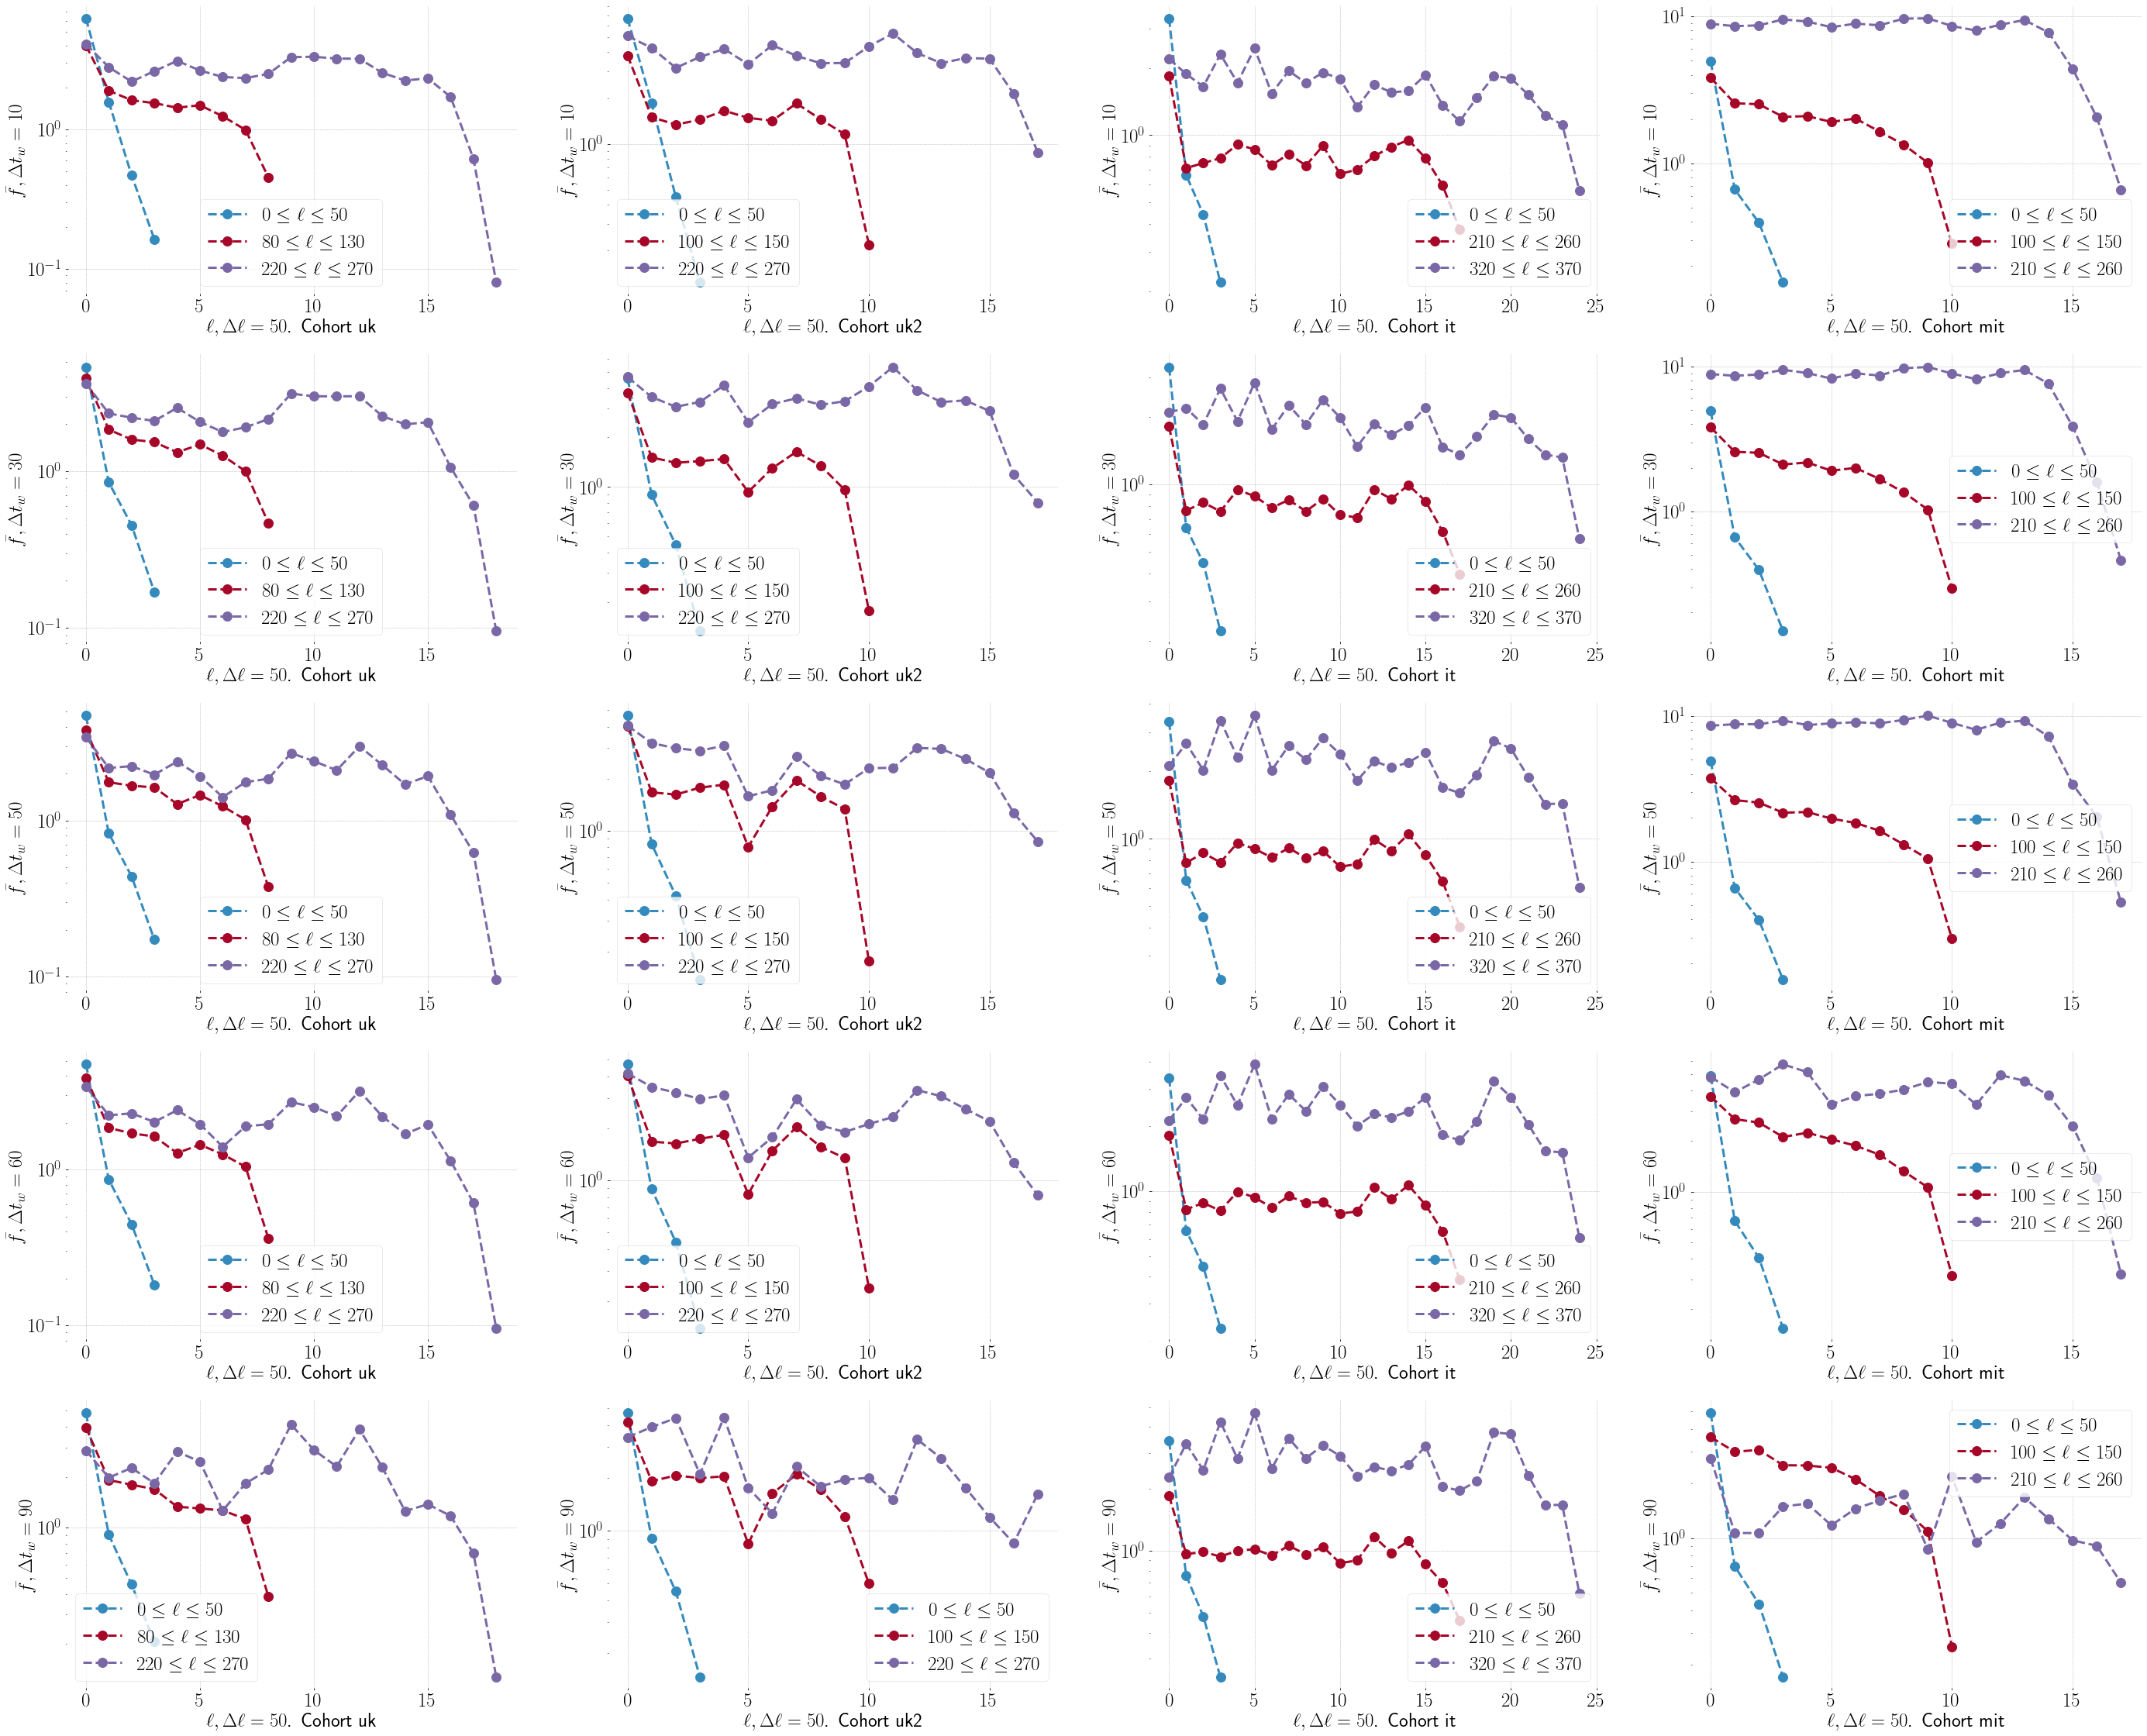

In [5]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Dt in S1['uk'].keys():
    for c in S1.keys():
        plt.subplot(5, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [6]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

In [7]:
S1['uk'].keys()

dict_keys([10, 30, 50, 60, 90])

## S2: Fig 1 with different values for $\Delta \ell$

In [8]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [9]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]

In [10]:
S2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            if c == 'it':
                S2[c][i][j] = {'f': pc.get_avgfa(itdffa15[60], itlives[60], lims[c][i][j][0], lims[c][i][j][1])}
            else:
                S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

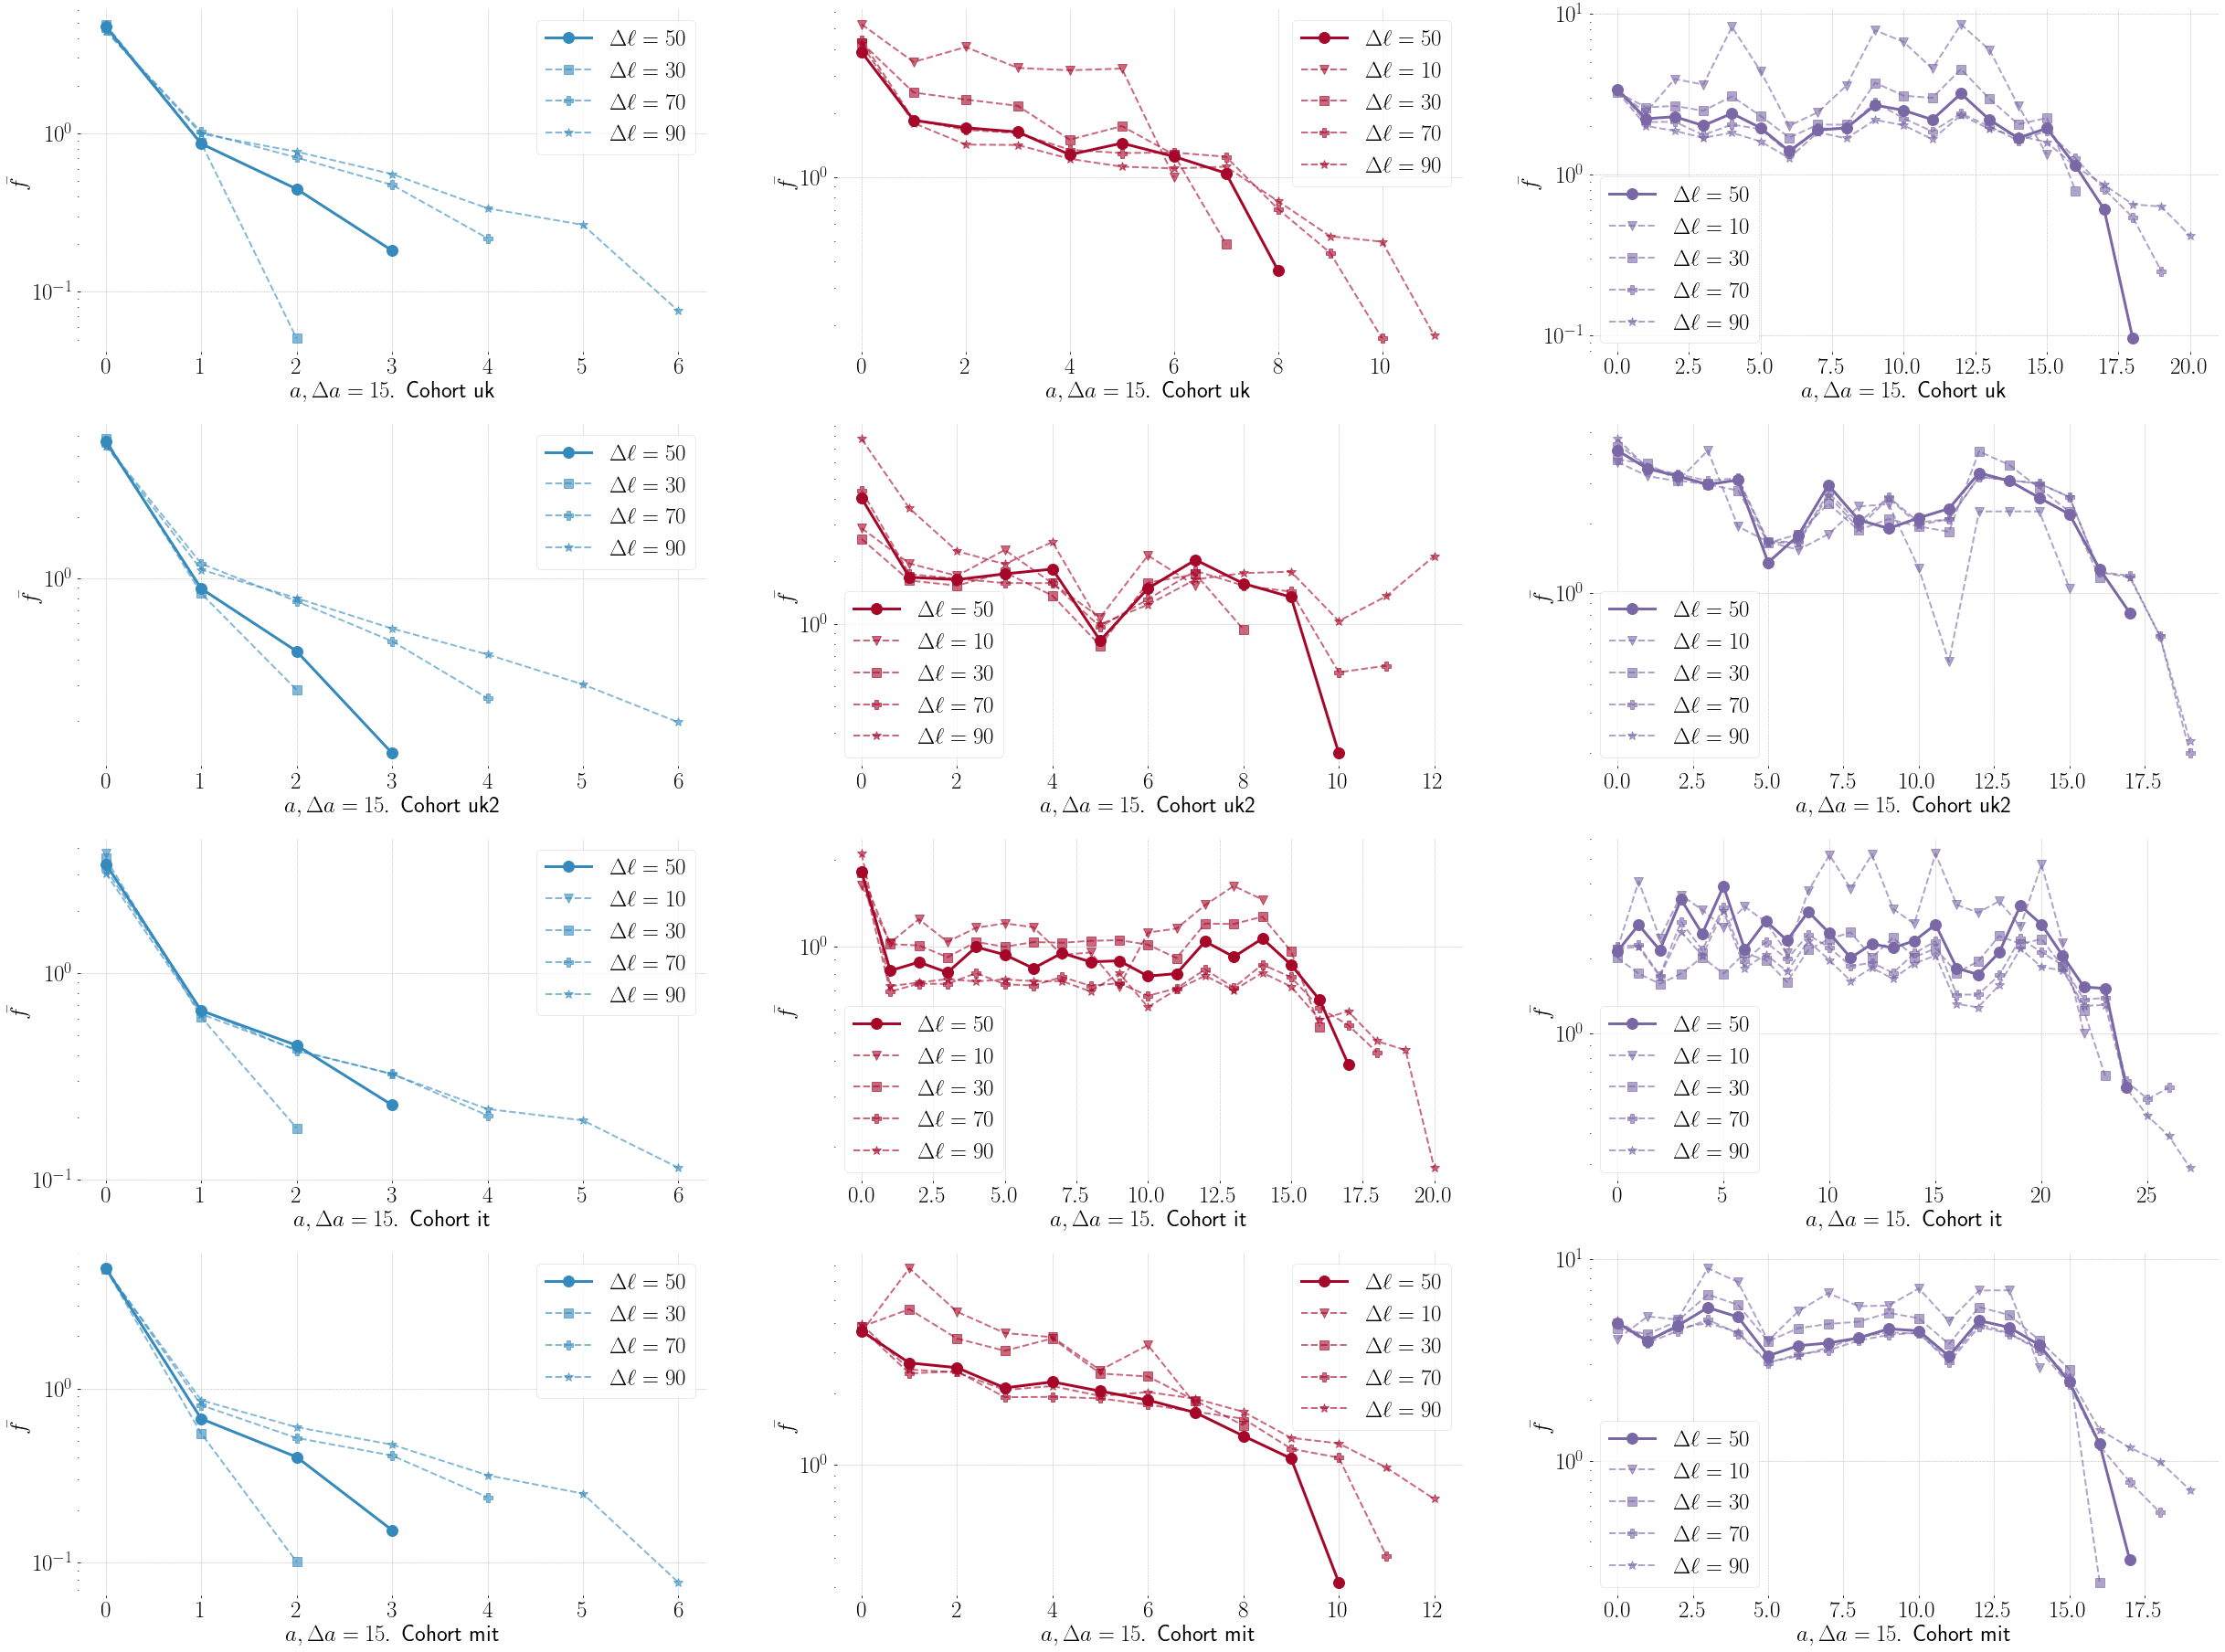

In [11]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [12]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1 with variations of $\Delta a$

In [63]:
Deltaa = {}
for c in ['uk', 'uk2', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            Deltaa[c][Da][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], Da)

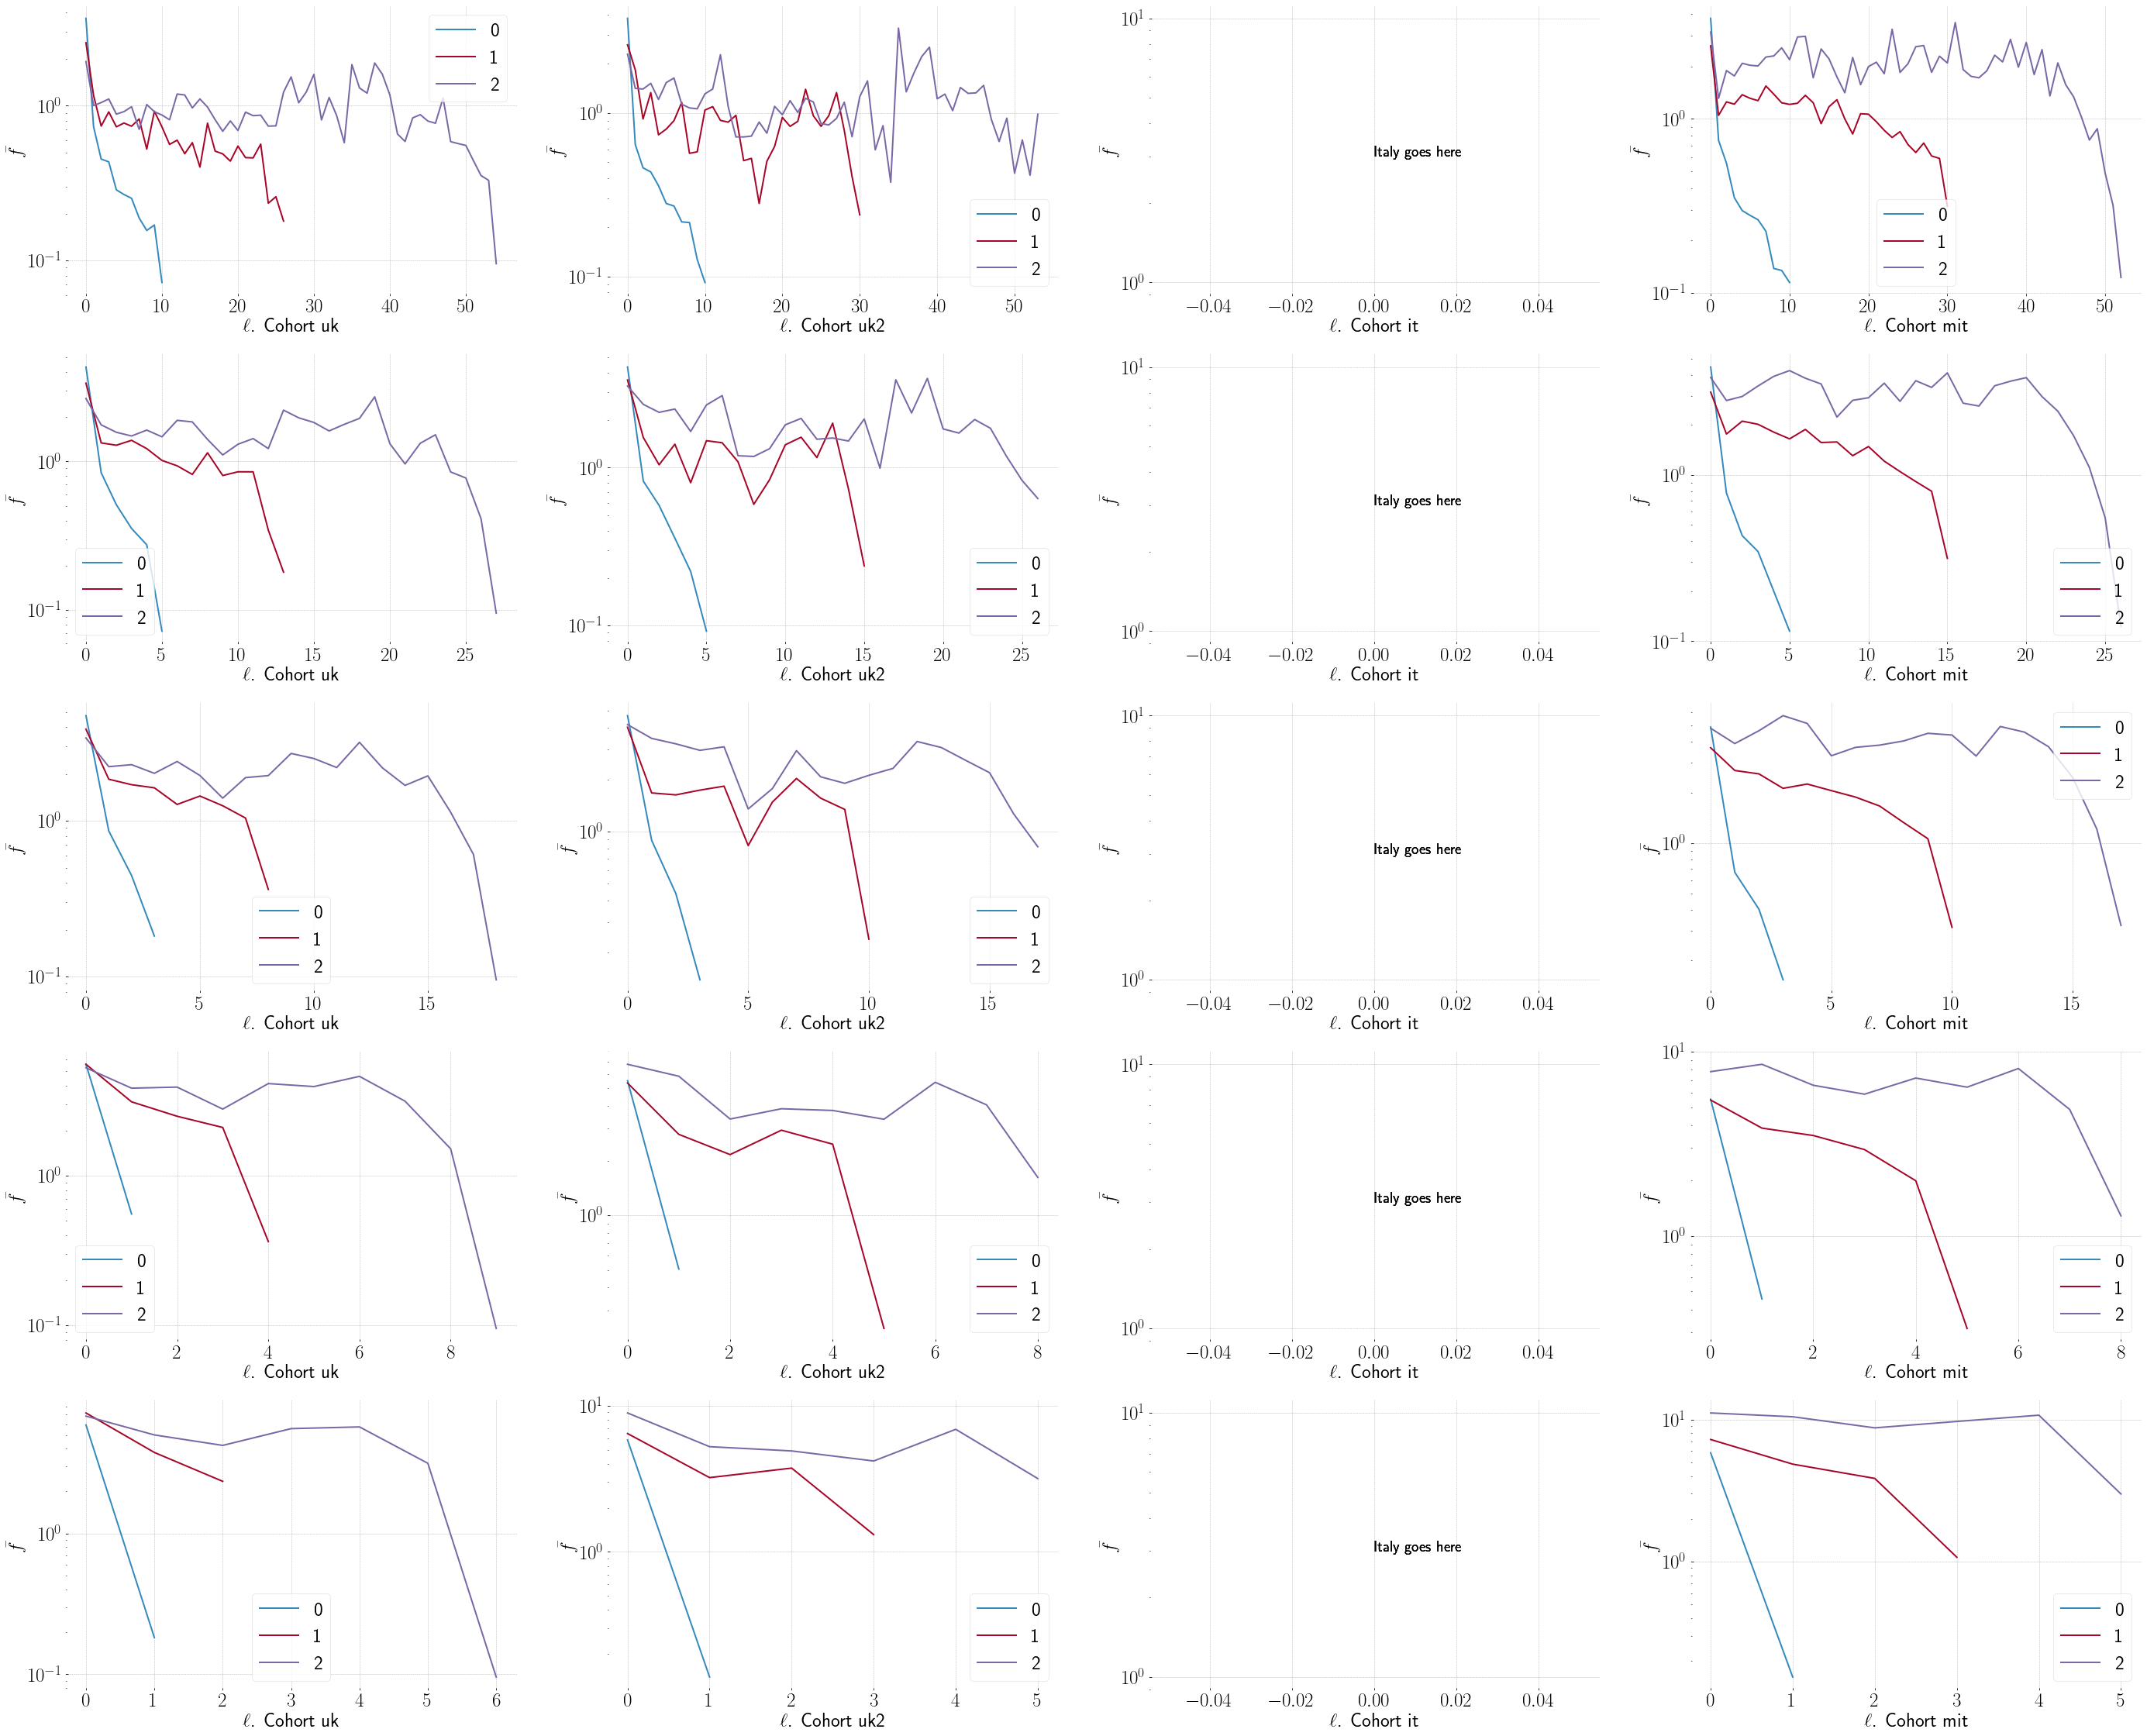

In [65]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        if c != 'it':
            plt.subplot(5,4,p)
            plt.xlabel(fr'$\ell$. Cohort {c}')
            plt.ylabel(r'$\bar{f}$')
            plt.semilogy()
            for i in range(3):
                plt.plot(Deltaa[c][Da][i]['f'].index, Deltaa[c][Da][i]['f']['f'], label=f'{i}')
            plt.legend()
            p += 1
        else:
            plt.subplot(5,4,p)
            plt.xlabel(fr'$\ell$. Cohort {c}')
            plt.ylabel(r'$\bar{f}$')
            plt.semilogy()
            for i in range(3):
                plt.annotate("Italy goes here", (0, 3), fontsize=20)
            p += 1

In [76]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]['f']
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

In [77]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

In [78]:
tmp

ukDax0    ukDay0 ukDax1    ukDay1 ukDax2    ukDay2 ukDbx0    ukDby0 ukDbx1  \
0     0.0  3.662629    0.0  2.548431    0.0   1.92586    0.0  4.320821    0.0   
1     5.0  0.731324    5.0  1.164406    5.0   1.00044   10.0  0.839558   10.0   
2    10.0  0.452249   10.0  0.738499   10.0  1.046908   20.0  0.511434   20.0   
3    15.0  0.433786   15.0  0.912191   15.0  1.104928   30.0  0.354108   30.0   
4    20.0  0.286256   20.0  0.730104   20.0  0.881522   40.0  0.275115   40.0   
5    25.0  0.266995   25.0  0.772482   25.0  0.915487   50.0  0.072239   50.0   
6    30.0  0.252363   30.0   0.73693   30.0   0.98438    nan       nan   60.0   
7    35.0  0.188385   35.0  0.820786   35.0  0.703431    nan       nan   70.0   
8    40.0  0.156433   40.0  0.524694   40.0  1.016725    nan       nan   80.0   
9    45.0  0.169659   45.0  0.921272   45.0  0.913954    nan       nan   90.0   
10   50.0  0.072239   50.0  0.730082   50.0  0.870376    nan       nan  100.0   
11    nan       nan   55.0  0.562178   55.0  0.811046    nan       nan  110.0   
12    nan       nan   60.0  0.599129   60.0  1.188587    nan       nan  120.0   
13    nan       nan   65.0  0.489669   65.0   1.17246    nan       nan  130.0   
14    nan       nan   70.0  0.577208   70.0  0.967369    nan       nan    nan   
15    nan       nan   75.0  0.401327   75.0  1.104993    nan       nan    nan   
16    nan       nan   80.0  0.771529   80.0  0.978869    nan       nan    nan   
17    nan       nan   85.0  0.508842   85.0   0.81172    nan       nan    nan   
18    nan       nan   90.0  0.488689   90.0  0.683639    nan       nan    nan   
19    nan       nan   95.0  0.438669   95.0   0.79712    nan       nan    nan   
20    nan       nan  100.0  0.548371  100.0  0.691587    nan       nan    nan   
21    nan       nan  105.0  0.461938  105.0  0.908761    nan       nan    nan   
22    nan       nan  110.0  0.460201  110.0  0.861813    nan       nan    nan   
23    nan       nan  115.0  0.564718  115.0   0.86836    nan       nan    nan   
24    nan       nan  120.0  0.234754  120.0  0.737639    nan       nan    nan   
25    nan       nan  125.0  0.258329  125.0  0.740789    nan       nan    nan   
26    nan       nan  130.0  0.180147  130.0  1.221904    nan       nan    nan   
27    nan       nan    nan       nan  135.0  1.533871    nan       nan    nan   
28    nan       nan    nan       nan  140.0  1.043948    nan       nan    nan   
29    nan       nan    nan       nan  145.0  1.226044    nan       nan    nan   
30    nan       nan    nan       nan  150.0  1.592512    nan       nan    nan   
31    nan       nan    nan       nan  155.0  0.809012    nan       nan    nan   
32    nan       nan    nan       nan  160.0    1.1295    nan       nan    nan   
33    nan       nan    nan       nan  165.0  0.861592    nan       nan    nan   
34    nan       nan    nan       nan  170.0  0.576592    nan       nan    nan   
35    nan       nan    nan       nan  175.0  1.843083    nan       nan    nan   
36    nan       nan    nan       nan  180.0  1.301263    nan       nan    nan   
37    nan       nan    nan       nan  185.0  1.204391    nan       nan    nan   
38    nan       nan    nan       nan  190.0  1.886213    nan       nan    nan   
39    nan       nan    nan       nan  195.0  1.597928    nan       nan    nan   
40    nan       nan    nan       nan  200.0  1.172707    nan       nan    nan   
41    nan       nan    nan       nan  205.0  0.656664    nan       nan    nan   
42    nan       nan    nan       nan  210.0  0.587468    nan       nan    nan   
43    nan       nan    nan       nan  215.0  0.833911    nan       nan    nan   
44    nan       nan    nan       nan  220.0  0.875162    nan       nan    nan   
45    nan       nan    nan       nan  225.0  0.795713    nan       nan    nan   
46    nan       nan    nan       nan  230.0  0.770222    nan       nan    nan   
47    nan       nan    nan       nan  235.0  1.121335    nan       nan    nan   
48    nan       nan    nan       n

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [13]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1[c][lamb]['f'], pstar=0.01)
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.654265084574468) -- (axis cs: 2, 0.654265084574468);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.4581887315198958) -- (axis cs: 7, 1.4581887315198958);
\draw[dashed, ekans, ultra thick] (axis cs: 5, 2.2256547446074486) -- (axis cs: 13, 2.2256547446074486);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.450963957437888) -- (axis cs: 13, 2.450963957437888);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8991669257367098) -- (axis cs: 15, 0.8991669257367098);
\draw

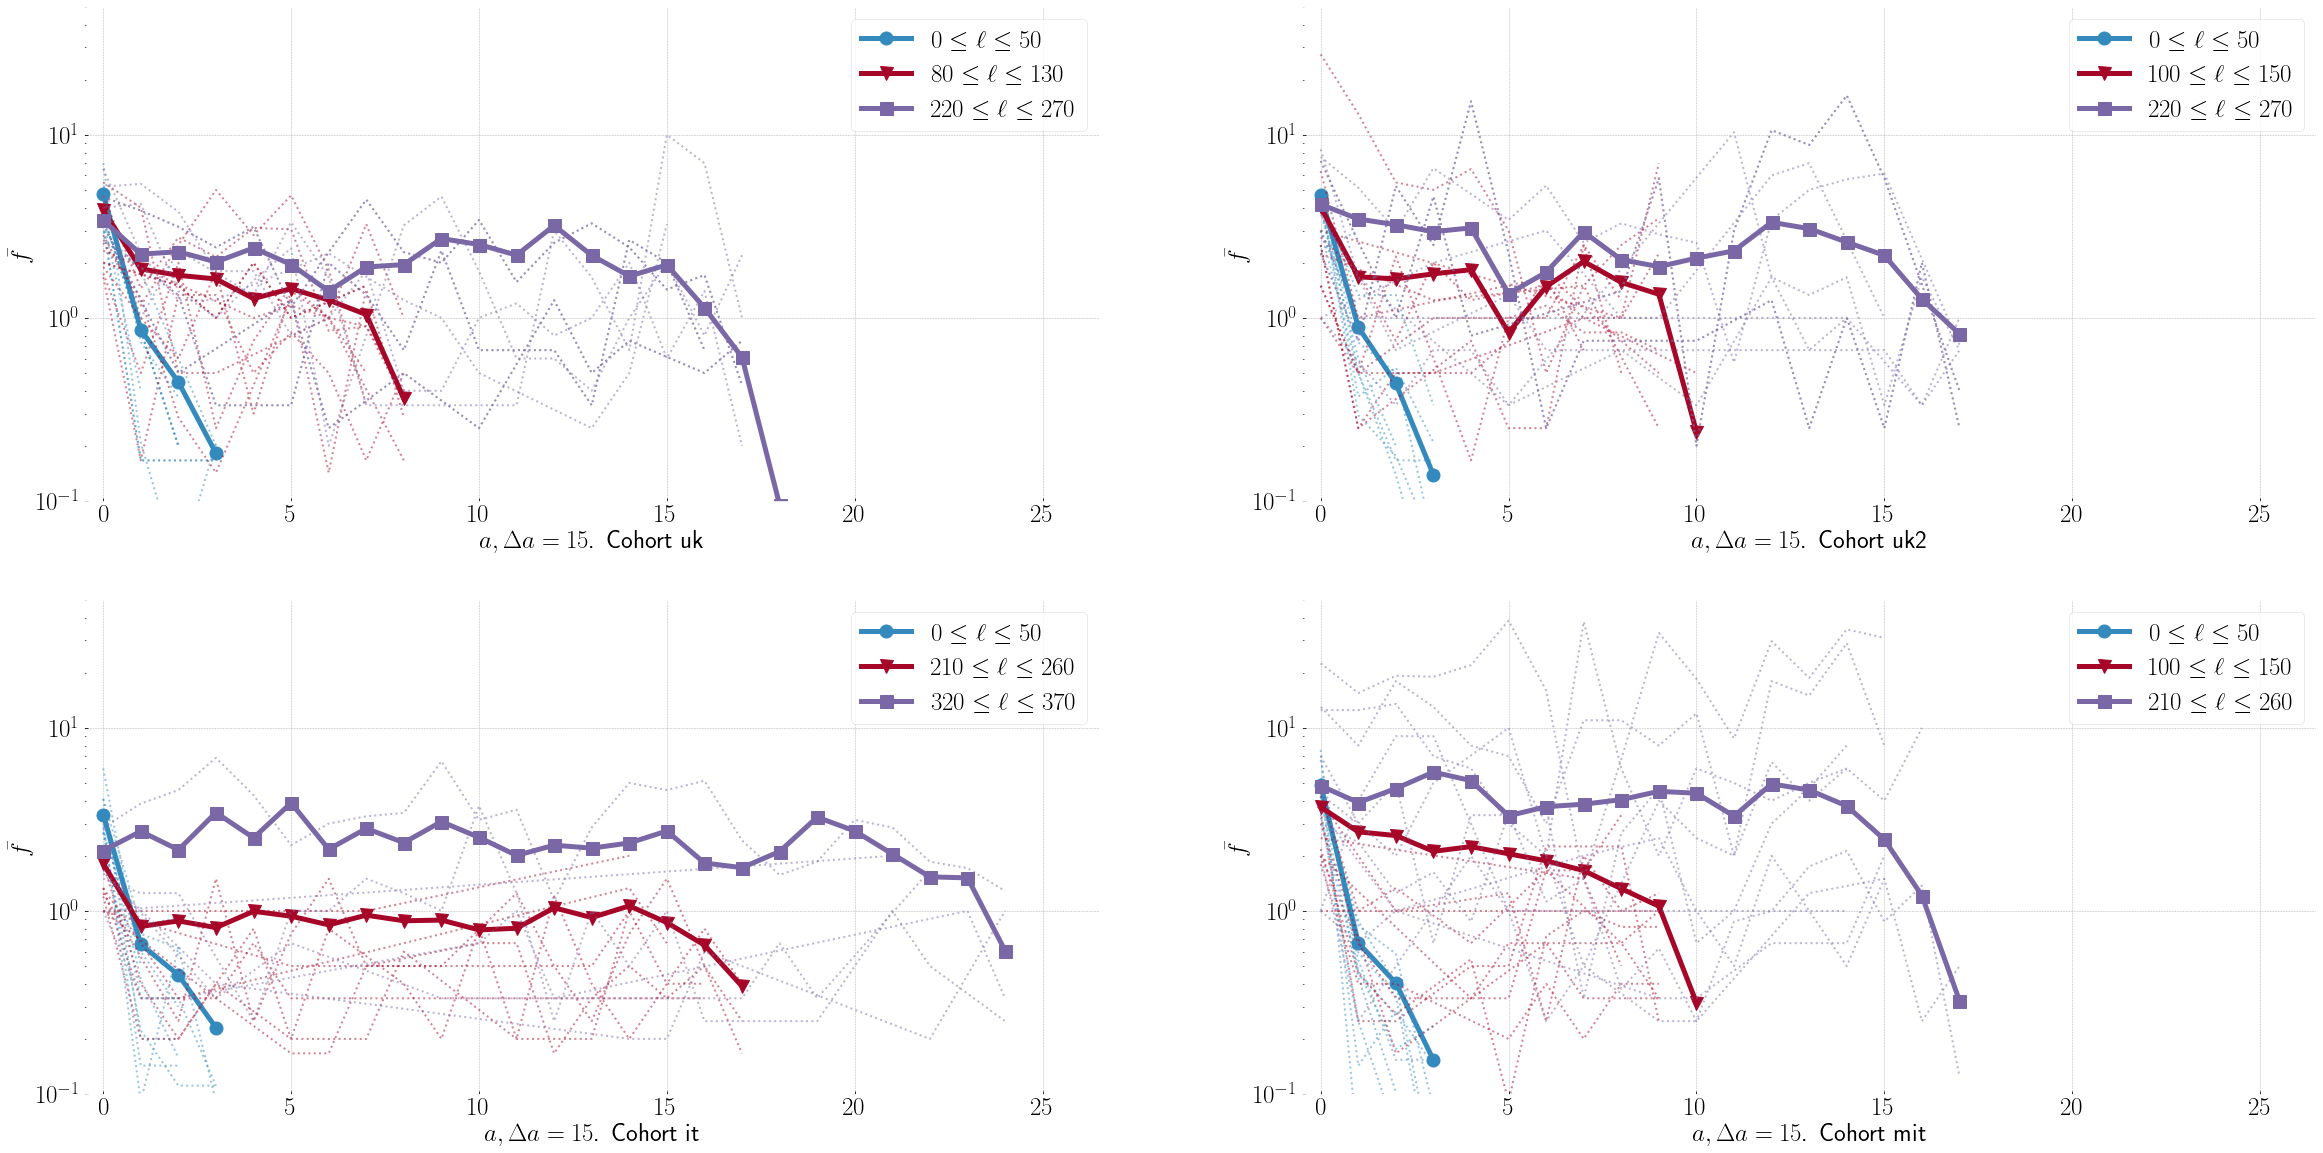

In [14]:
np.random.seed(2)
tmp = pd.DataFrame(index=range(25))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [15]:
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

## Different tests for $b(\ell)$

In [40]:
def get_b_olstocenter(series, pstar=0.1):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        X = sm.add_constant(series.index)
        Y = series['f']
        tmp = sm.OLS(Y, X).fit()
        if tmp.pvalues[1] > pstar:
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]
    
def get_b_slopes(series, patternsize=3):
    allslopes = []
    X = list(series.index)
    N = len(X)
    xo, xf = X[0], X[-1]
    yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
    slope = (yf - yo) / (xf - xo)
    allslopes.append(slope)
    for i in range(1, N):
        newx = X[i // 2: N - ((i + 1) // 2)]
        if len(newx) > 1:
            xo, xf = newx[0], newx[-1]
            yo, yf = series.at[xo, 'f'], series.at[xf, 'f']
            slope = (yf - yo) / (xf - xo)
            allslopes.append(slope)
        else:
            xo, xf = X[1], X[-2]
            df = series.loc[(series.index >= xo) & (series.index <= xf)]
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
        if (len(allslopes) >= patternsize):
            checkSlopes = list(np.sign(allslopes[-patternsize:]))
            if checkSlopes.count(checkSlopes[0]) != len(checkSlopes):
                df = series.loc[(series.index >= xo) & (series.index <= xf)]
                yo = np.mean(df['f'])
                yf = yo
                return [[xo, xf], [yo, yf]]

def get_b_mk(series):
    for i in range(max(series.index) // 2):
        df = series.loc[(series.index >= (0 + i)) & (series.index <= (max(series.index) - i))]
        tmp = mk.original_test(df['f'])
        if tmp[0] == 'no trend':
            df = series.loc[(series.index >= (0 + i - 1)) & (series.index <= (max(series.index) - i + 1))]
            xo = min(df.index)
            xf = max(df.index)
            yo = np.mean(df['f'])
            yf = yo
            return [[xo, xf], [yo, yf]]
    else:
        df = series.loc[(series.index >= (0 + 1)) & (series.index <= (max(series.index) - 1))]
        xo = min(df.index)
        xf = max(df.index)
        yo = np.mean(df['f'])
        yf = yo
        return [[xo, xf], [yo, yf]]

In [41]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for ego in itlives[60].keys():
    for alter in itlives[60][ego].keys():
        if itlives[60][ego][alter]['ell'] > maxit:
            maxit = itlives[60][ego][alter]['ell']
maxa['it'] = maxit
maxa

{'uk': 482, 'uk2': 291, 'mit': 442, 'it': 633}

In [45]:
t0 = dt.datetime.now()
tests = ['olsToEnds', 'olsToCenter', 'mk', 'slopes']
functs = [pc.get_plateau, get_b_olstocenter, get_b_mk, get_b_slopes]
fa = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    fa[c] = {}
    for t in tests:
        fa[c][t] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            curve  = {'f': pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50)}
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15)
        if len(curve['f']) > 3:
            for ft in range(len(tests)):
                points = functs[ft](curve['f'])
                fa[c][tests[ft]][ell] = points[1][1]
    for t in fa[c].keys():
        fa[c][t] = pd.DataFrame.from_dict(fa[c][t], orient='index').sort_index()
print(f'Took {dt.datetime.now() - t0}')

/opt/homebrew/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Took 0:01:31.181132


In [47]:
tmp = pd.DataFrame(index=range(366))
for c in fa.keys():
    for test in ['mk', 'slopes']:
        df = fa[c][test].loc[fa[c][test].index <= 365]
        df[f'{c}{test}'] = df[0].rolling(window=50).mean()
        df = df.drop(columns=[0])
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

/var/folders/c1/dbn37n492mz65yl47z1jb0sc0000gn/T/ipykernel_2027/770552025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{c}{test}'] = df[0].rolling(window=50).mean()


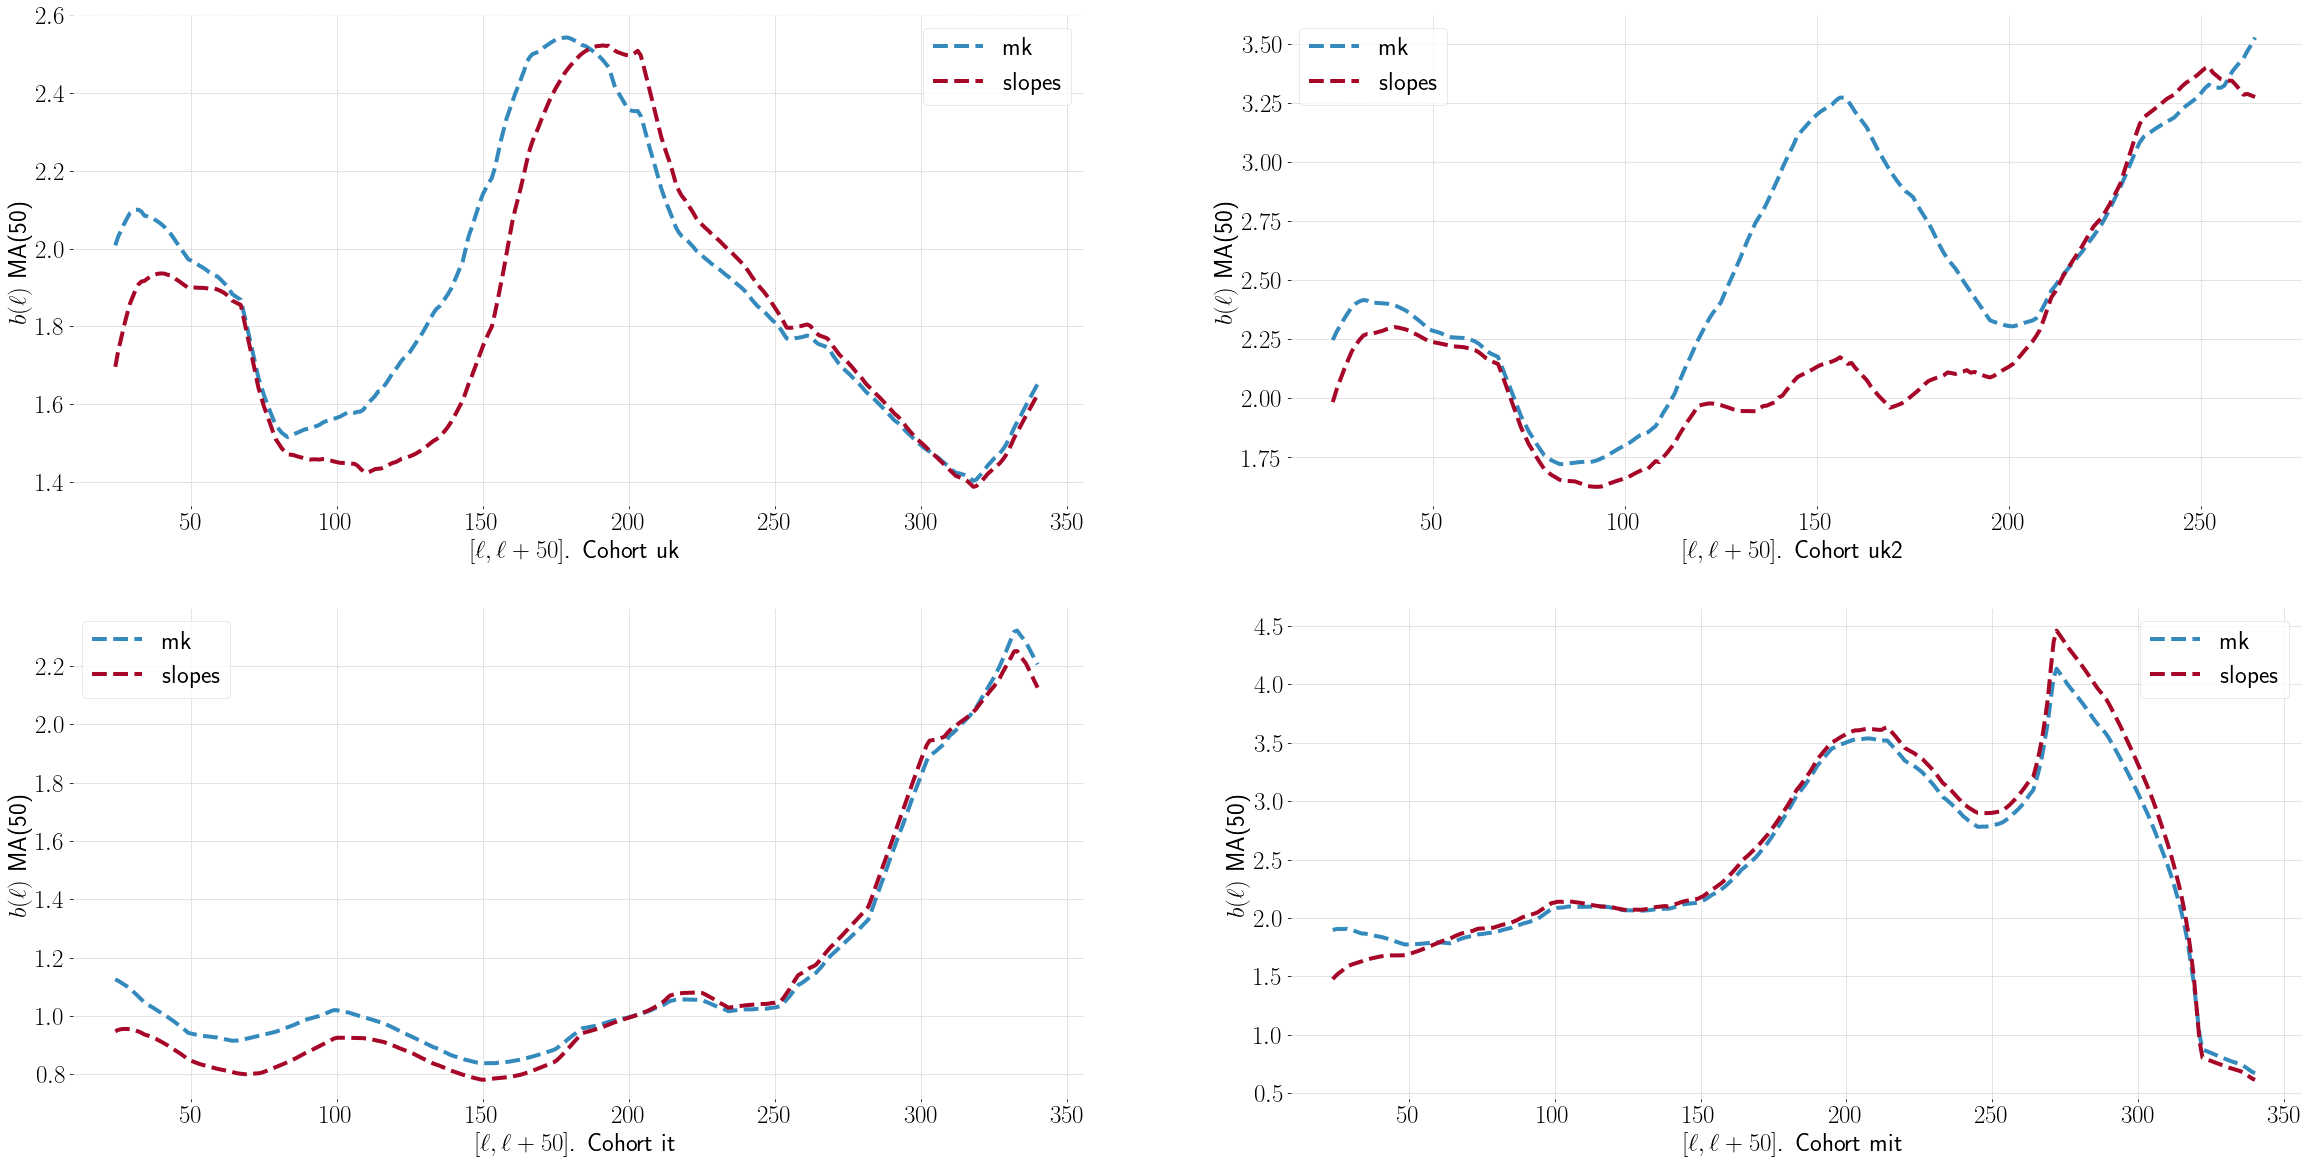

In [48]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$[\ell, \ell + 50]$. Cohort {c}")
    plt.ylabel(r"$b(\ell)$ MA(50)")
    for test in ['mk', 'slopes']:
        plt.plot([x - 25 for x in tmp.index], tmp[f'{c}{test}'], markersize=13, ls="dashed", lw=4, label=test)
    plt.legend()
    p += 1

In [ ]:
# tmp = tmp.fillna('nan')
# tmp.index = [x - 25 for x in tmp.index]
# tmp = tmp.loc[tmp.index >= 24]
# tmp.index.rename('a', inplace=True)
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", sep="\t")

## Individual egos and their plateaus

In [49]:
t0 = dt.datetime.now()

limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    for lamb in fig1[c].keys():
        points = get_b_slopes(fig1[c][lamb]['f'])
        dashed[c][lamb] = points[1][1]
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.842256


In [50]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])
                    
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

/Users/vsvh/Documents/research/comm_patterns_git/phonecalls.py:667: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [51]:
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'it', 'mit']:
    for lamb in range(3):
        hist = histogram(bhist[c][lamb], 5, log=False)
        tmp[f'{c}x{lamb}'] = hist['label']
        tmp[f'{c}y{lamb}'] = hist['pmf']

In [52]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", sep="\t", index=False)

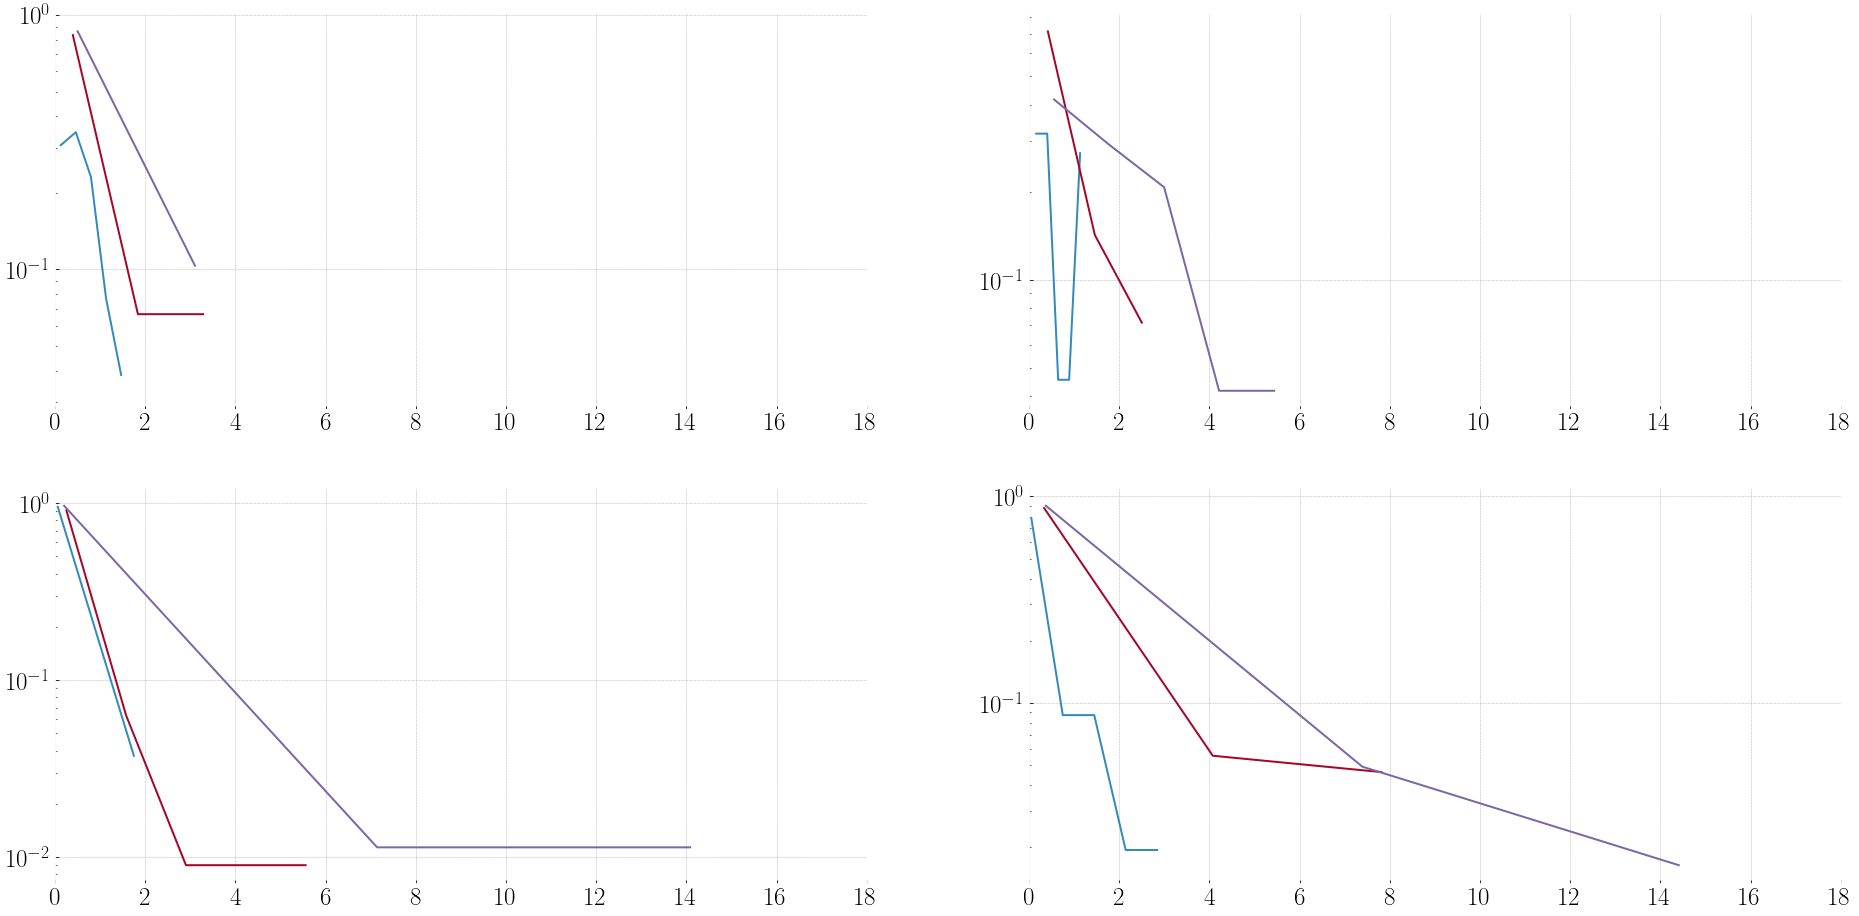

In [53]:
plt.figure(figsize=(16*2, 8*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.semilogy()
    plt.xlim(0, 18)
    for lamb in range(3):
        plt.plot(tmp[f'{c}x{lamb}'], tmp[f'{c}y{lamb}'])
    p += 1

## $p$-value distribution for the KS test

In [54]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8534285714285715, 0.04) (0.8534285714285715, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.646031746031746, 0.04) (0.646031746031746, 1)};
============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8125850340136055, 0.04) (0.8125850340136055, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.6950757575757575, 0.04) (0.6950757575757575, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8681966417260535, 0.04) (0.8681966417260535, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8444142544761739, 0.04) (0.8444142544761739, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.7817754262198706, 0.04) (0.7817754262198706, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7682993236271923, 0.04) (0.7682993236271923, 1)};


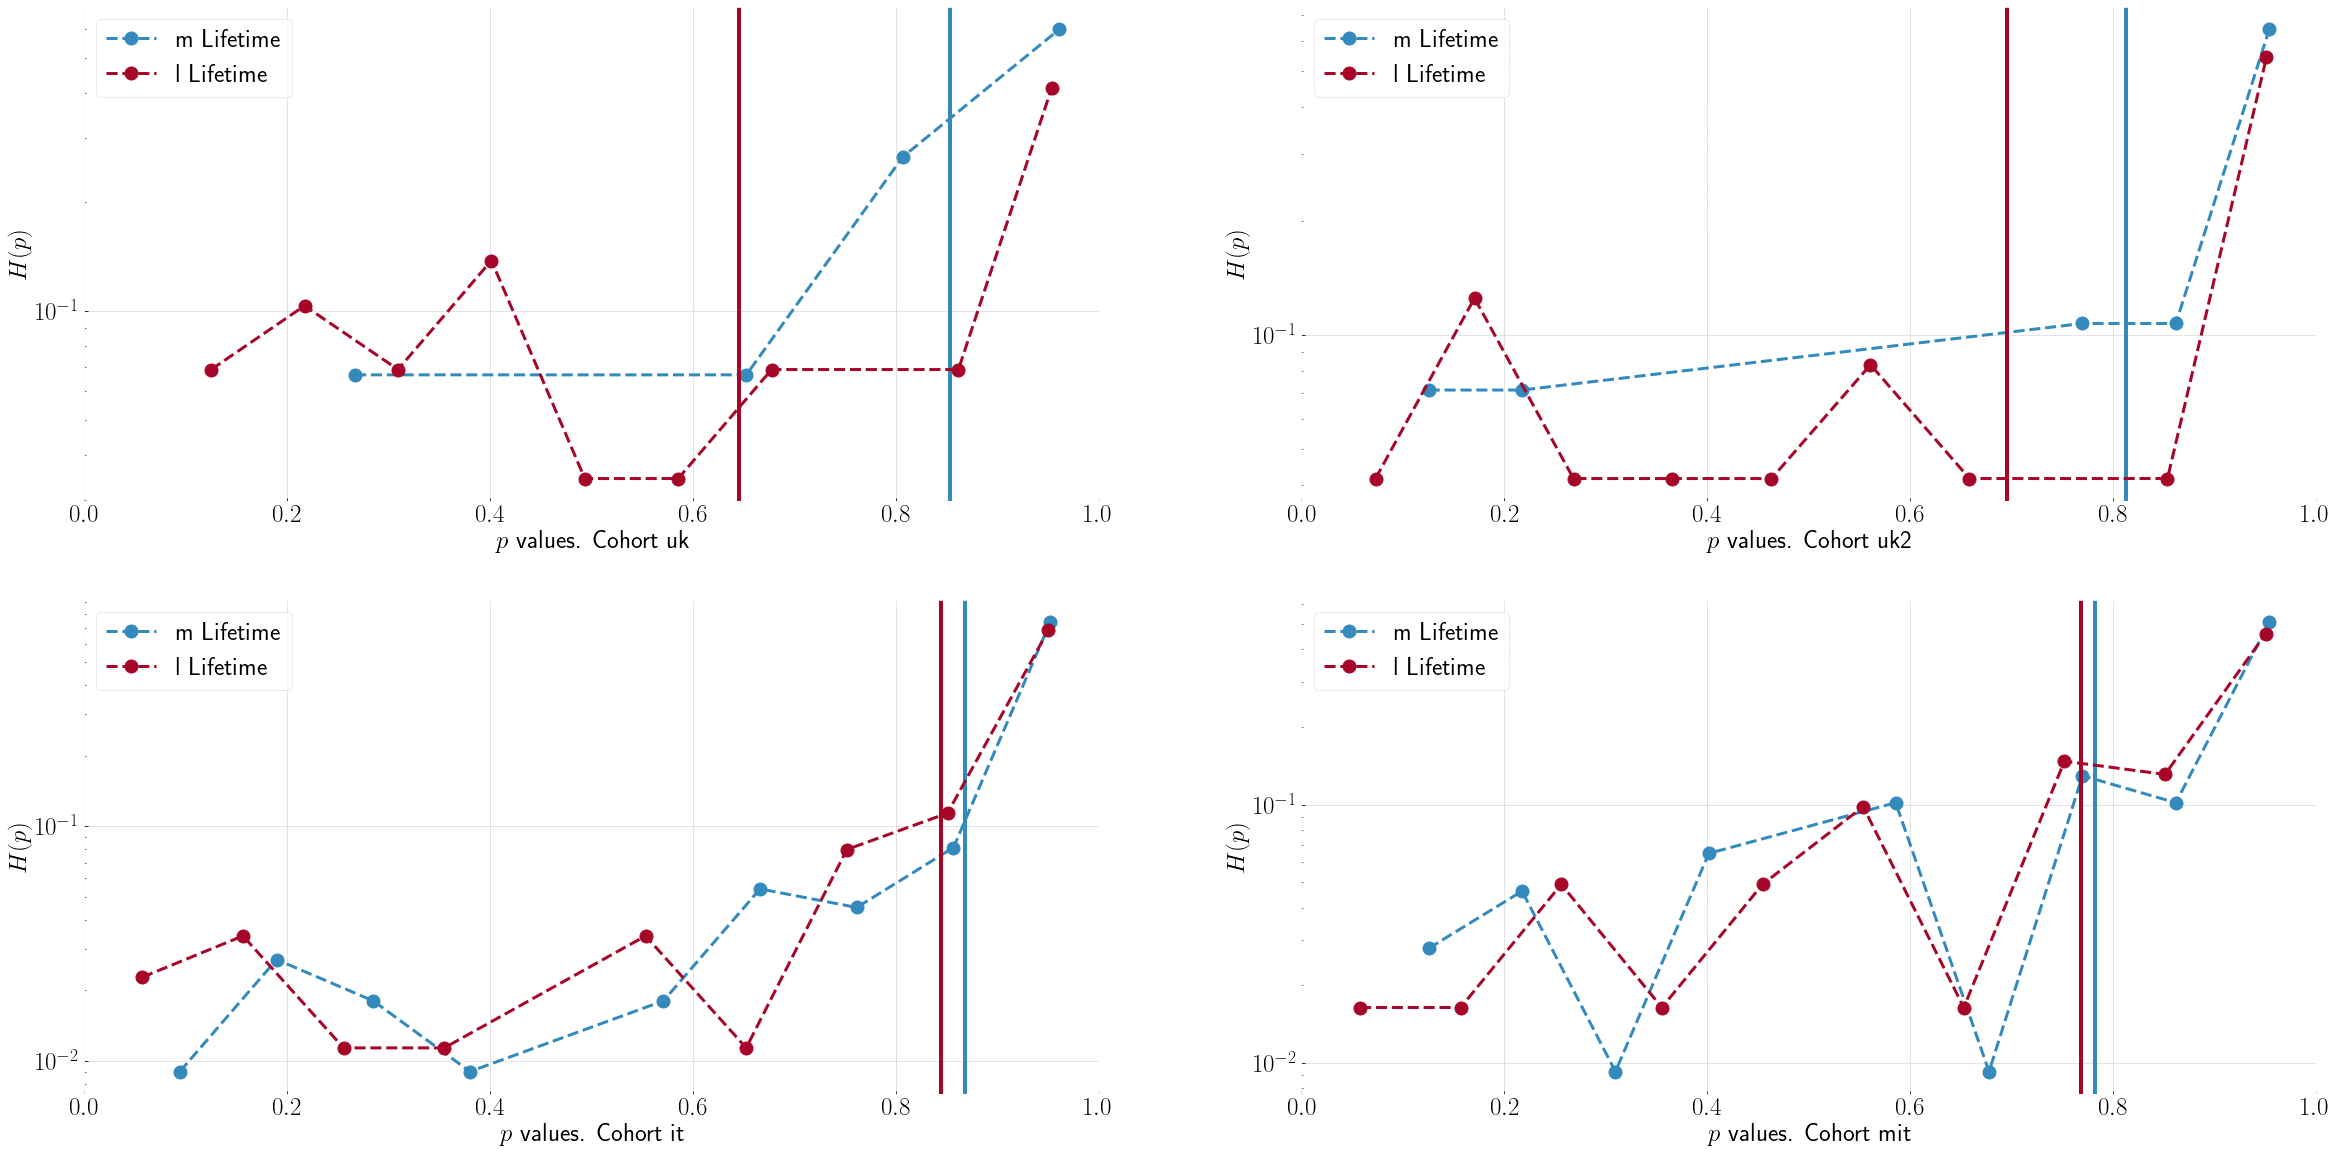

In [55]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA1.pdf")

# Attempt to scale fig 3

In [16]:
dff30 = {}
dff30['all'] = {}
for c in calls.keys():
    dff30[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff30['all'].update(dff30[c])
    
dff30['it'] = itdffa30[60]
dff30['all'].update(dff30['it'])

In [17]:
lives = {}
lives['all'] = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])
lives['it'] = itlives[60]
lives['all'].update(lives['it'])

In [18]:
survival = {}
for c in dff30.keys():
    survival[c] = pc.get_survival(dff30[c], lambdamax=25)

In [19]:
t0 = dt.datetime.now()
b = {}
converge = {}
for ell in range(251):
    curve = pc.get_avgfa(dff30['all'], lives['all'], ell, ell + 50)
    if len(curve) > 2:
        points = pc.get_b_slopes(curve, FlagConverge=True)
        b[ell] = points[1][1]
        converge[ell] = points[2]
b = pd.DataFrame.from_dict(b, orient='index').sort_index().rename({0: 'b'}, axis='columns')
tmp = pd.DataFrame.from_dict(converge, orient="index").sort_index().rename({0: 'converge'}, axis='columns')
b = b.merge(tmp, left_index=True, right_index=True, how='outer')
b['ma50'] = b['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:12.951939


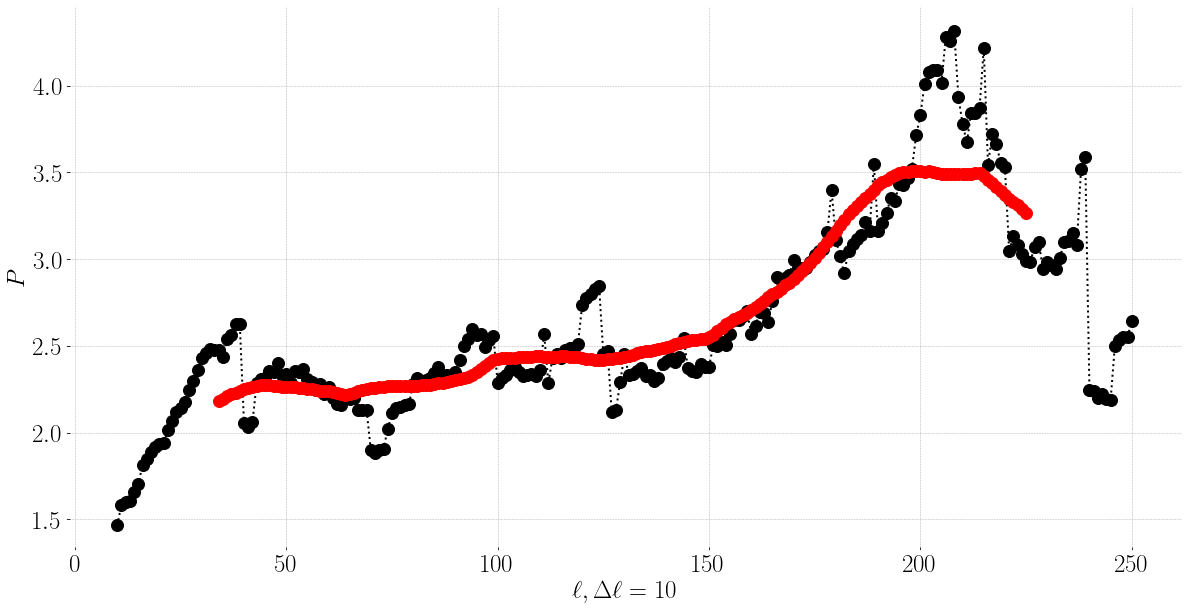

In [20]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
plt.plot(b.index, b['b'], marker="o", markersize=12, ls="dotted", c="black")
plt.plot([x - 25 for x in b.index], b['ma50'], marker="o", markersize=12, ls="dotted", c="red")

In [21]:
for i in range(6):
    g = 2**(i + 1)
    print(((60 - 30)*g) / 30)

2.0
4.0
8.0
16.0
32.0
64.0


# Rolling window using Italy

and making the distinction between IT1 and IT2

In [22]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()

In [80]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for c in ['it', 'it1', 'it2']:
    if c == 'it':
        lvs = itlives[60]
    else:
        lvs = tmplives[c][60]
    for ego in lvs.keys():
        for alter in lvs[ego].keys():
            if lvs[ego][alter]['ell'] > maxit:
                maxit = lvs[ego][alter]['ell']
    maxa[c] = maxit
maxa

{'uk': 482, 'uk2': 291, 'mit': 442, 'it': 633, 'it1': 633, 'it2': 633}

In [81]:
t0 = dt.datetime.now()
b = {}
b2 = {}
nalt = {}
nego = {}
for c in ['uk', 'uk2', 'it', 'mit', 'it1', 'it2']:
    b[c] = {}
    b2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            tmpres = pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50, countalt=True)
            curve  = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        elif (c == 'it1') or (c == 'it2'):
            tmpres = pc.get_avgfa(tmpdff[c][60], tmplives[c][60], ell, ell + 50, countalt=True)
            curve = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15, countalters=True)
        if len(curve['f']) > 2:
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            points2 = get_b_mk(curve['f'])
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            if c in ['it', 'it1', 'it2']:
                nalt[c][ell] = tmpn
                nego[c][ell] = tmpeg
            else:
                nalt[c][ell] = curve['nalters']
                nego[c][ell] = curve['egocount']
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmp = pd.DataFrame.from_dict(b2[c], orient="index").sort_index().rename({0: 'mk'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:25.179219


In [84]:
b['it']

slopes        mk  nalt  nego
0    0.551796  1.173717  1369   142
1    0.661494  1.222153  1116   140
2    0.751057  1.252894   997   138
3    0.785887  1.272244   954   138
4    0.823517  1.285534   908   138
..        ...       ...   ...   ...
628  1.571429  1.210526     4     4
629  1.800000  1.307692     3     3
630  1.800000  1.307692     3     3
631  2.333333  1.400000     2     2
632  2.666667  1.555556     1     1

[633 rows x 4 columns]

In [101]:
# for c in b.keys():
#     df = b[c].copy(deep=True)
#     df.columns = [1,2,3,4]
#     df.index.rename('ell', inplace=True)
#     df.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S4{c}.dat", index=True, header=True, sep="\t")

In [94]:
# tmp = pd.DataFrame(index=range(633))
# for c in b.keys():
#     df = b[c].copy(deep=True)
#     if c not in ['uk2', 'it1', 'it2']:
#         df.columns = [f'{c}0', f'{c}1', f'{c}2', f'{c}3']
#     elif c == 'uk2':
#         df.columns = ['ukb0', 'ukb1', 'ukb2', 'ukb3']
#     elif c == 'it1':
#         df.columns = ['ita0', 'ita1', 'ita2', 'ita3']
#     elif c == 'it2':
#         df.columns = ['itb0', 'itb1', 'itb2', 'itb3']
#     tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

In [95]:
# tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv('../commpatterns/PNAS_paper/SI/figs/S4.dat', header=True, index=True, sep="\t")

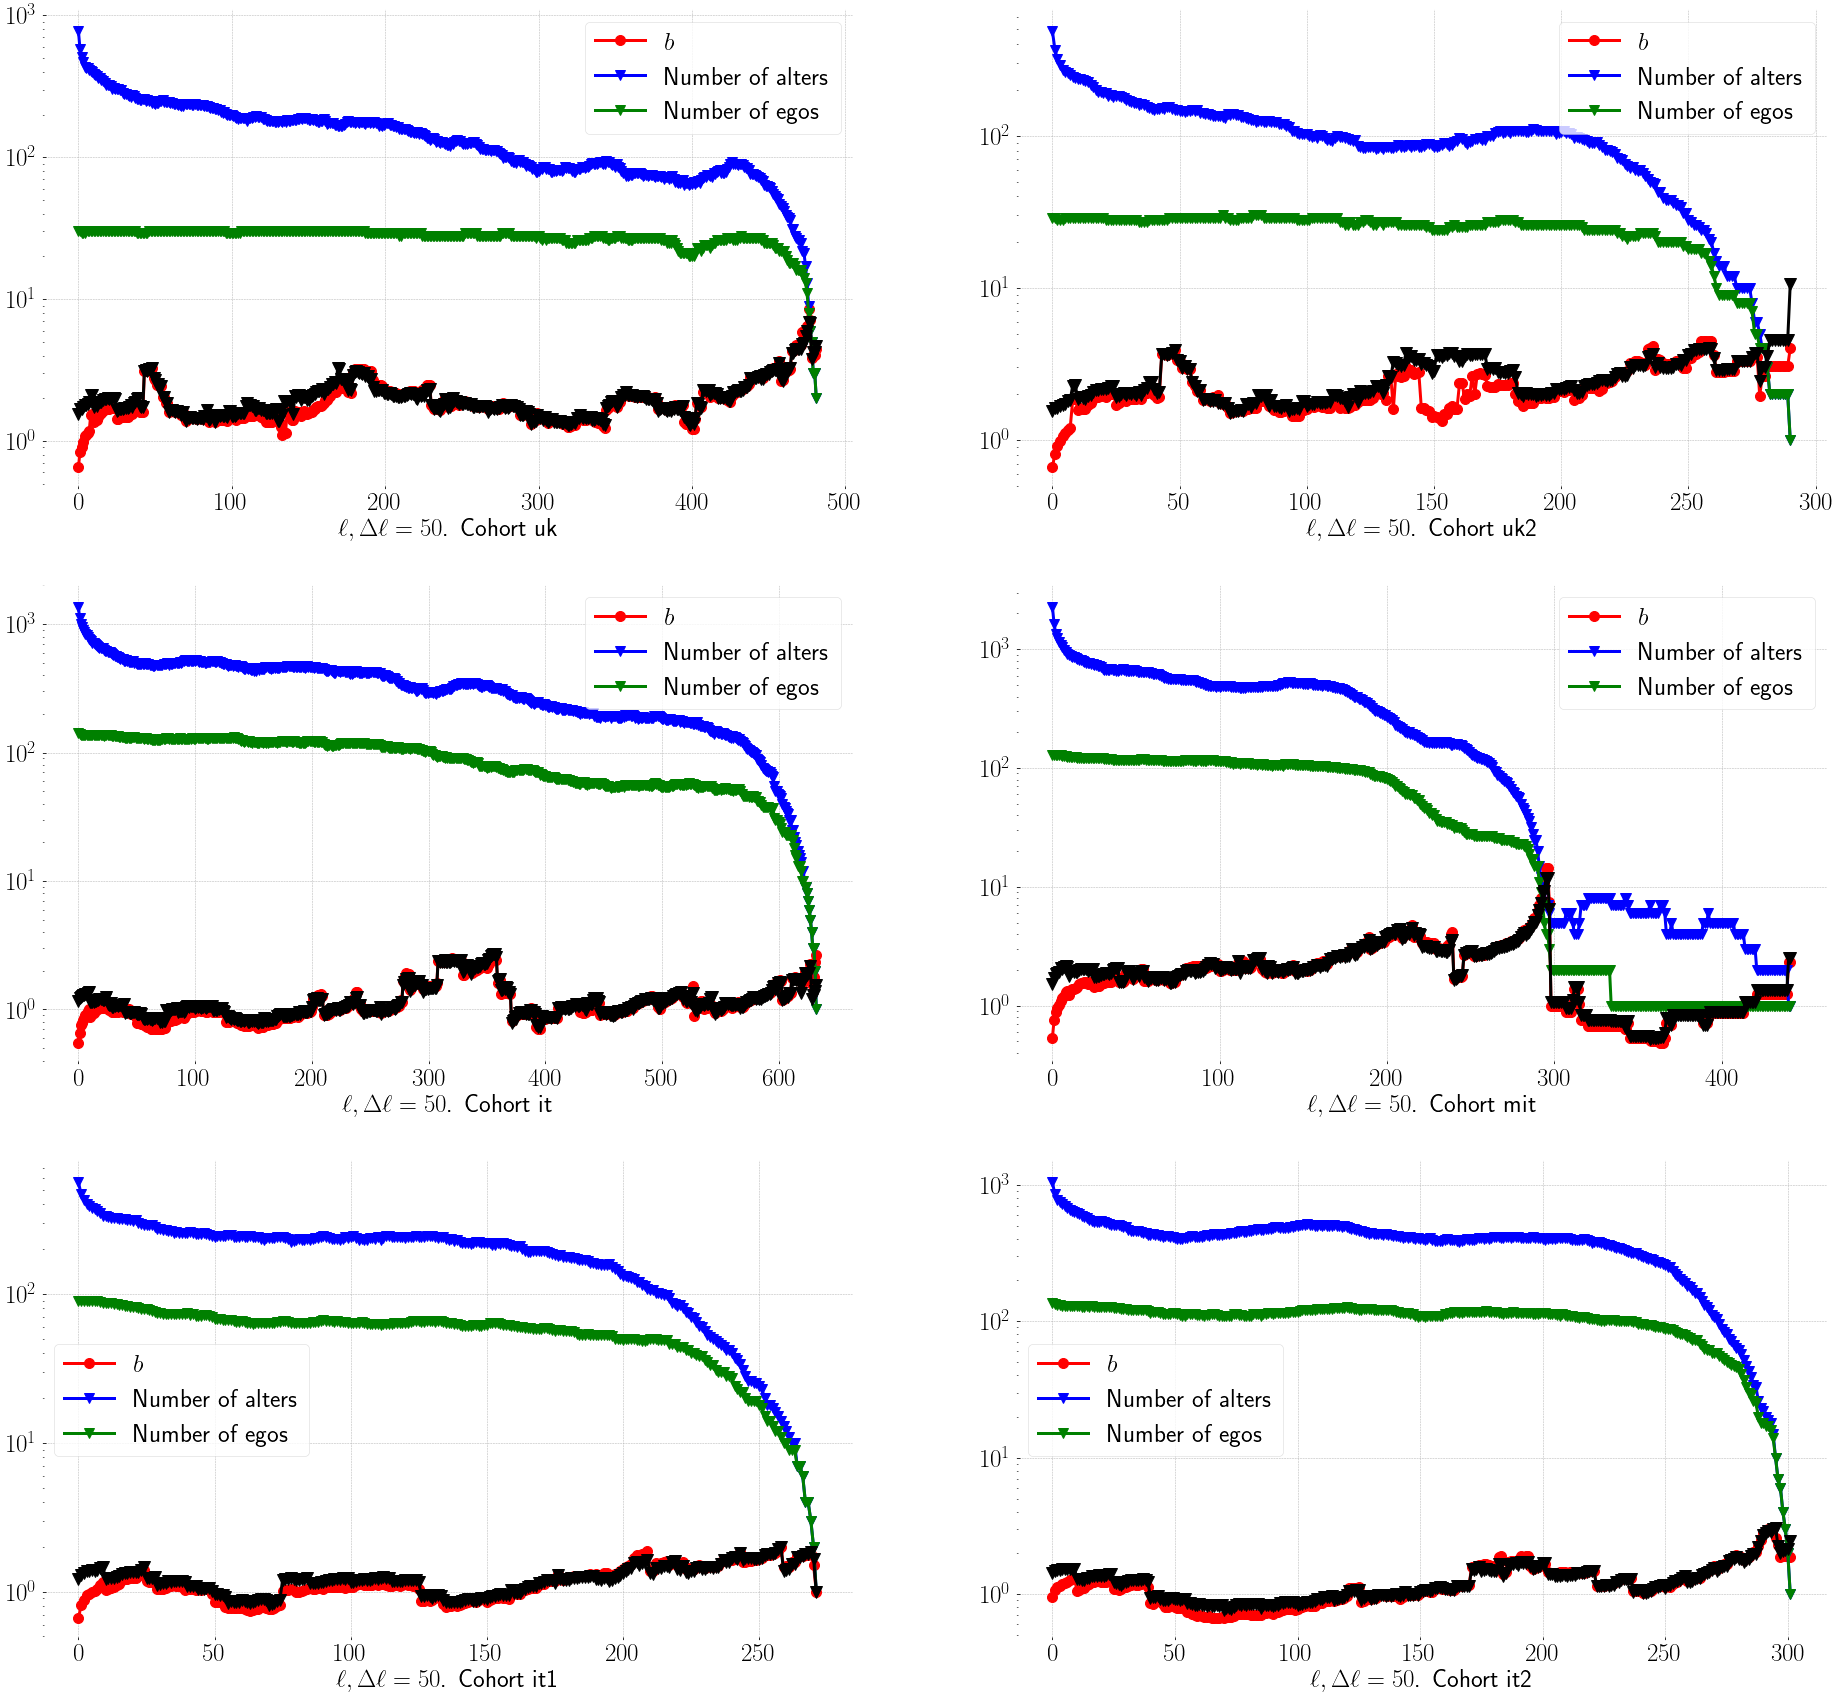

In [83]:
plt.figure(figsize=(16*2, 10*3))
p = 1
for c in b.keys():
    plt.subplot(3,2,p)
    plt.semilogy()
    plt.xlabel(fr'$\ell, \Delta \ell = 50$. Cohort {c}')
    plt.plot(b[c].index, b[c]['slopes'], marker=markers[0], markersize=10, ls="solid", lw=3, c="red", label=r'$b$')
    plt.plot(b[c].index, b[c]['nalt'], marker=markers[1], markersize=10, ls="solid", lw=3, c="blue", label=r'Number of alters')
    plt.plot(b[c].index, b[c]['nego'], marker=markers[1], markersize=10, ls="solid", lw=3, c="green", label=r'Number of egos')
    plt.plot(b[c].index, b[c]['mk'], marker=markers[1], markersize=12, ls="solid", lw=3, c="black")
    plt.legend()
    p += 1

In [85]:
b['it']

slopes        mk  nalt  nego
0    0.551796  1.173717  1369   142
1    0.661494  1.222153  1116   140
2    0.751057  1.252894   997   138
3    0.785887  1.272244   954   138
4    0.823517  1.285534   908   138
..        ...       ...   ...   ...
628  1.571429  1.210526     4     4
629  1.800000  1.307692     3     3
630  1.800000  1.307692     3     3
631  2.333333  1.400000     2     2
632  2.666667  1.555556     1     1

[633 rows x 4 columns]

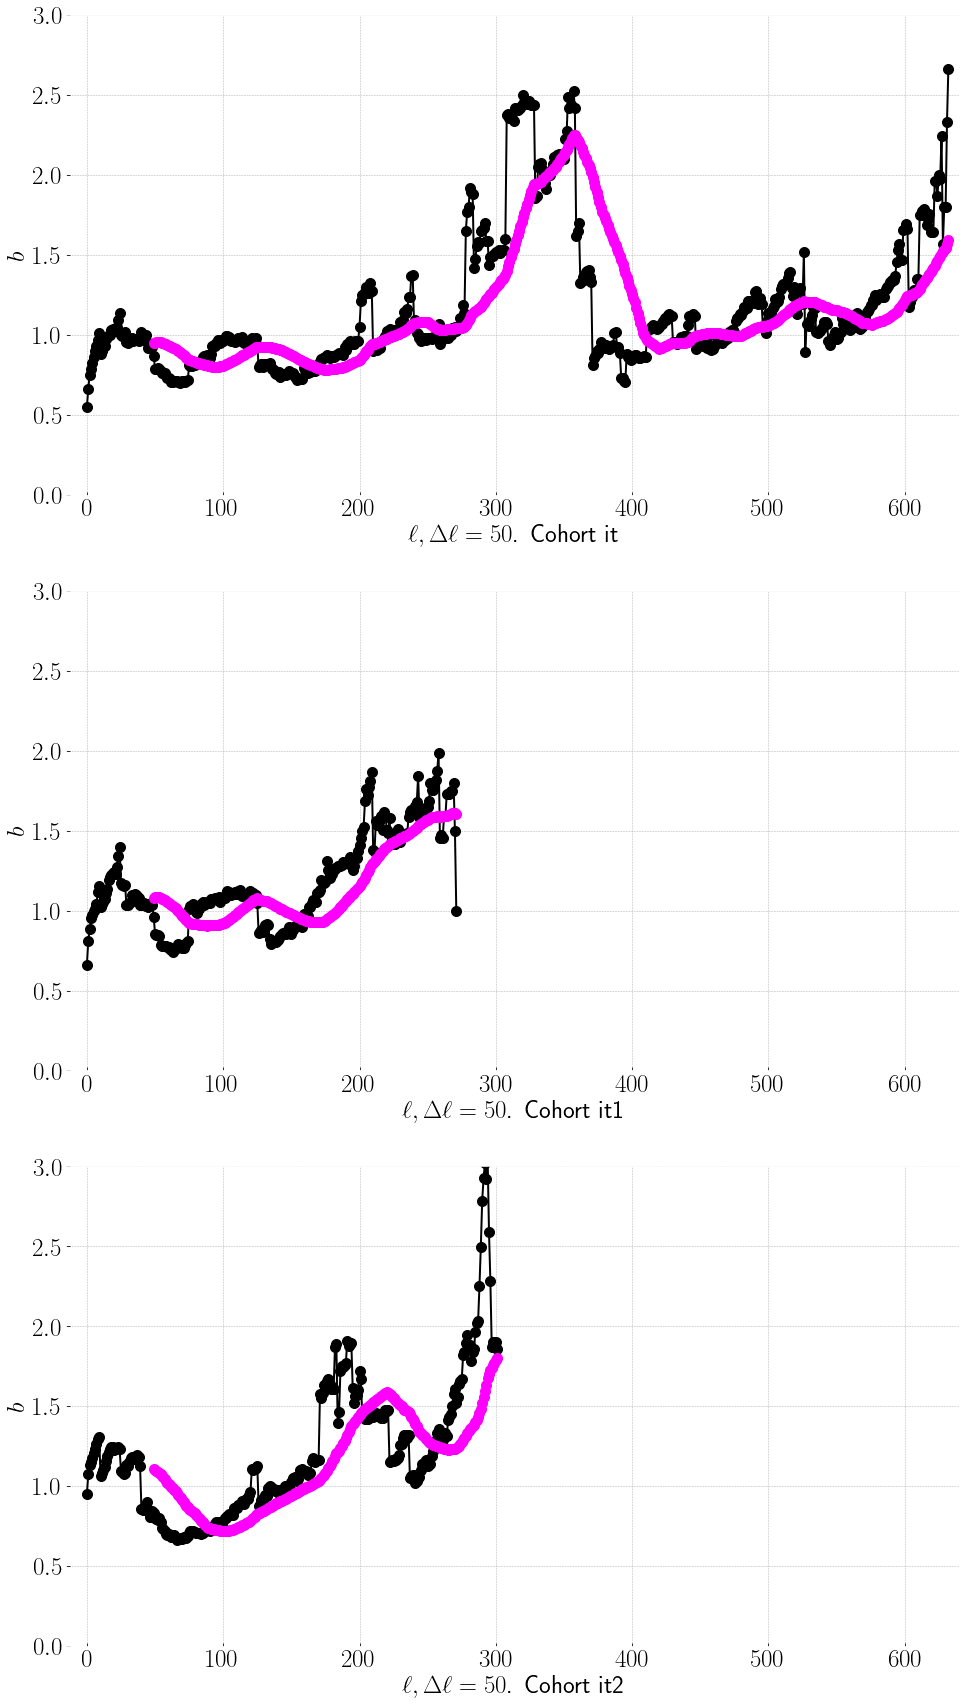

In [26]:
plt.figure(figsize=(16, 30))
p = 1
for c in ['it', 'it1', 'it2']:
    plt.subplot(3,1,p)
    plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
    plt.ylabel(r'$b$')
    plt.xlim(-15, 640)
    plt.ylim(0, 3)
    plt.plot(b[c].index, b[c]['b'], marker="o", markersize=10, c="black")
    plt.plot(b[c].index, b[c]['ma50'], marker="o", markersize=10, c="magenta")
    p += 1

# Fig 1 using only Italy


In [27]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['it1'] = [(0, 50), (100, 150), (210, 260)]
limits['it2'] = [(0, 50), (160, 210), (290, 340)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [28]:
fig1_it = {}
for c in ['it', 'it1', 'it2']:
    fig1_it[c] = {}
    for i in range(3):
        fig1_it[c][i] = pc.get_avgfa(tmpdff[c][60], tmplives[c][60], limits[c][i][0], limits[c][i][1])

In [29]:
dashed = {}
for c in ['it', 'it1', 'it2']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1_it[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1_it[c][lamb], pstar=0.01)
            points = pc.get_b_slopes(fig1_it[c][lamb])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8991669257367098) -- (axis cs: 15, 0.8991669257367098);
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2.5036360856719075) -- (axis cs: 20, 2.5036360856719075);
=======================it1=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6624829454614143) -- (axis cs: 2, 0.6624829454614143);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.079247026162641) -- (axis cs: 8, 1.079247026162641);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.3781133288057583) -- (axis cs: 14, 1.3781133288057583);
=======================it2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.9503502544298754) -- (axis cs: 2, 0.9503502544298754);
\draw[dashed, squirtle, ultra thick] (axis cs: 3, 1.0908861301916237) -- (axis cs: 11, 1.0908861301916237);
\

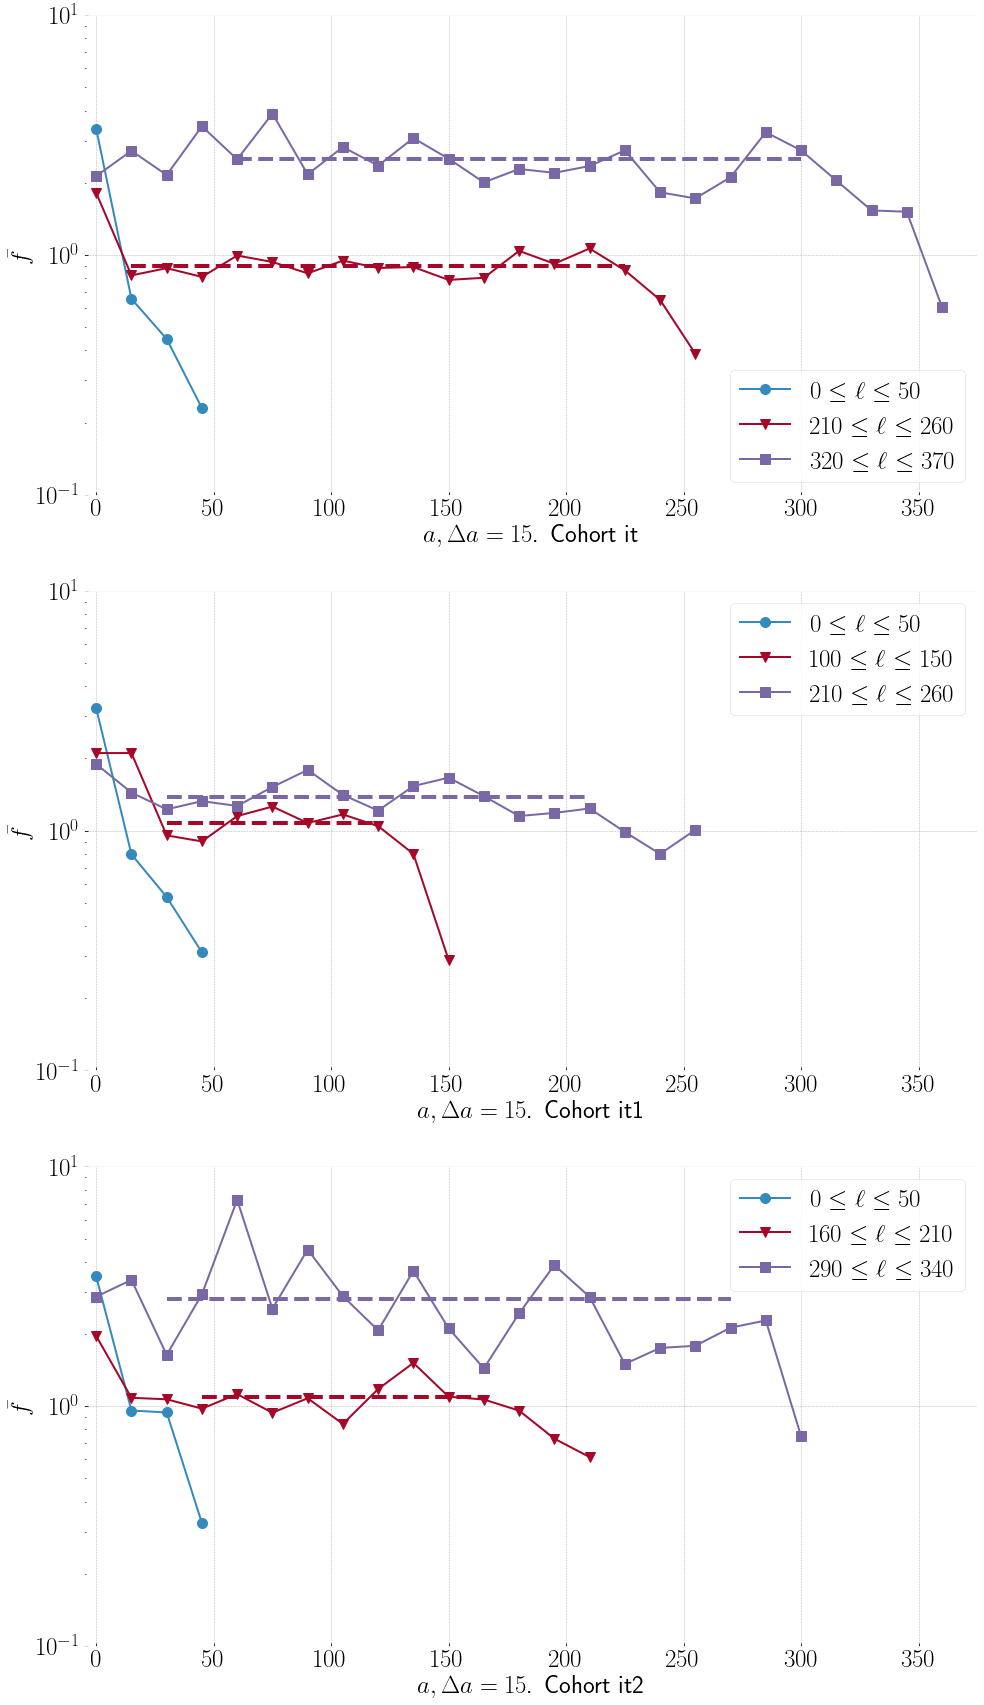

In [30]:
plt.figure(figsize=(16, 30))
p = 1
for c in fig1_it.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    plt.semilogy()
    plt.xlim(-5, 375)
    plt.ylim(0.1, 10)
    for i in range(3):
        plt.plot([x * 15 for x in fig1_it[c][i].index], fig1_it[c][i]['f'], marker=markers[i], markersize=10, ls="solid", lw=2, c=colors[i], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
        if i > 0:
            plt.plot([x * 15 for x in dashed[c][i][0]], dashed[c][i][1], marker="", ls="--", lw=4, c=colors[i])
    plt.legend()
    p += 1

# Quick result for proportion of lives and calls

For each series in Fig 1 (main paper); I have to count how many alters and how many phone calls out of the total we have **used** for the analysis

In [31]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [32]:
lives = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    
lives['it'] = itlives[60]

In [33]:
counts = {}
for c in ['uk', 'uk2', 'mit', 'it']:
    counts[c] = {}
    for i in range(1, 21):
        alters = 0
        ncalls = 0
        a = 0
        cc = 0
        for ego in lives[c].keys():
            for alter in lives[c][ego].keys():
                vol = lives[c][ego][alter]['nij']
                if vol > i:
                    alters += 1
                    ncalls += vol
                    ell = lives[c][ego][alter]['ell']
                    if (ell >= limits[c][0][0] and ell <= limits[c][0][1]) or (ell >= limits[c][1][0] and ell <= limits[c][1][1]) or (ell >= limits[c][2][0] and ell <= limits[c][2][1]):
                        a += 1
                        cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(1, 21)], 'calls': [counts[c][i][1] for i in range(1, 21)]}, index=range(1, 21))

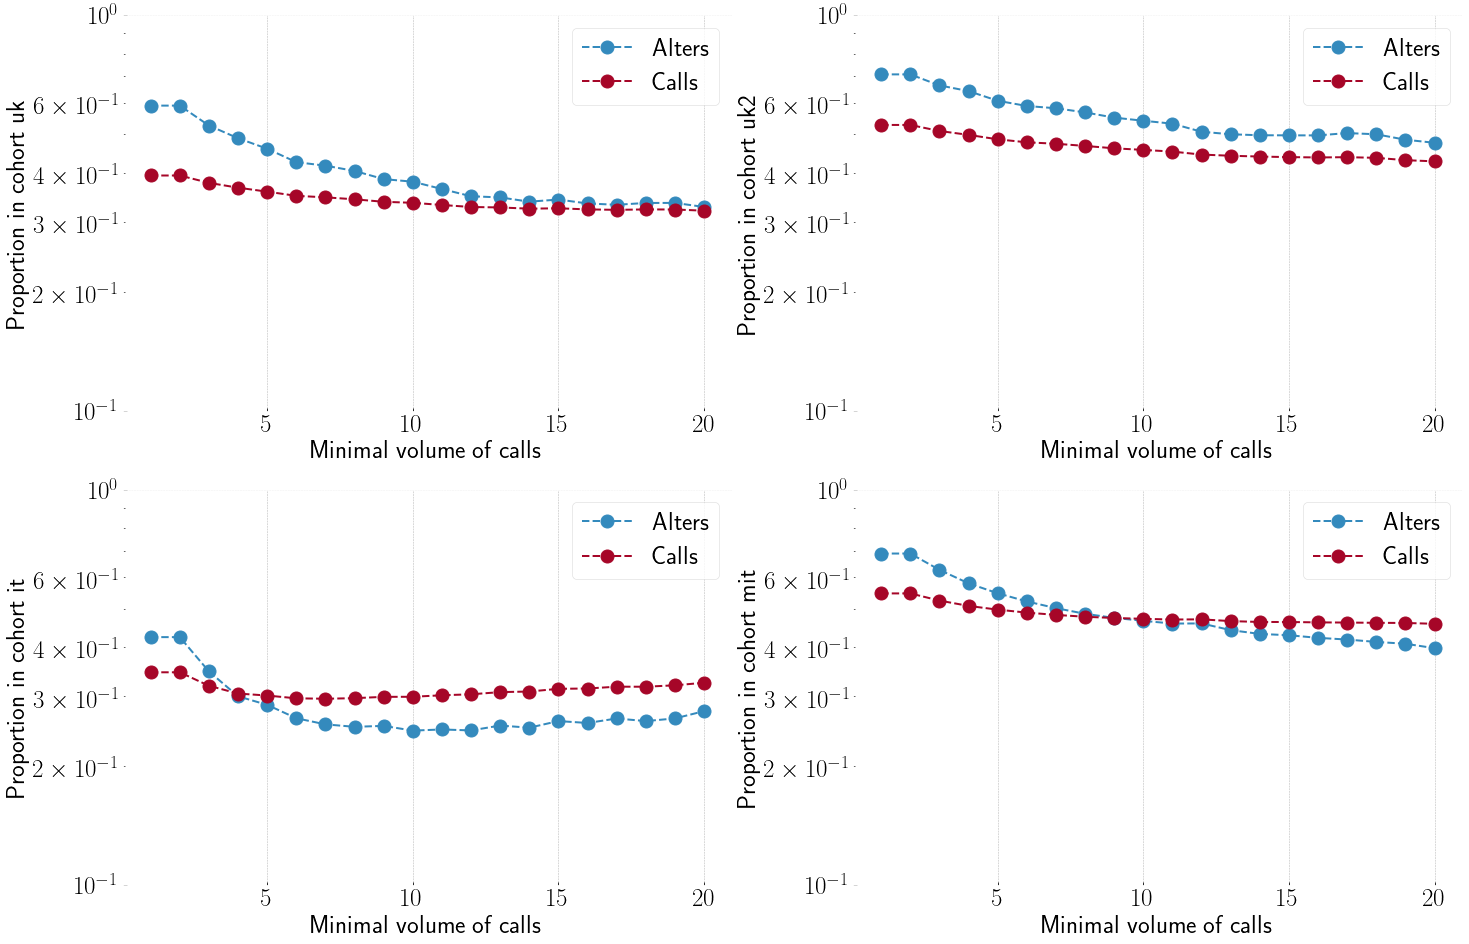

In [34]:
plt.figure(figsize=(12*2, 8*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel("Minimal volume of calls")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [35]:
tmp = {}
for c in ['uk', 'uk2', 'mit']:
    tmp[c] = pc.lives_dictionary(unfiltered[c])
    
counts = {}
for c in ['uk', 'uk2', 'mit']:
    alters = 0
    ncalls = 0
    a = 0
    cc = 0
    counts[c] = {}
    for i in range(10, 301, 10):
        tmpc = pc.apply_filters(unfiltered[c], i)
        tmpl = pc.lives_dictionary(tmpc)
        for ego in tmp[c].keys():
            for alter in tmp[c][ego].keys():
                vol = tmp[c][ego][alter]['nij']
                alters += 1
                ncalls += vol
                if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
                    a += 1
                    cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))

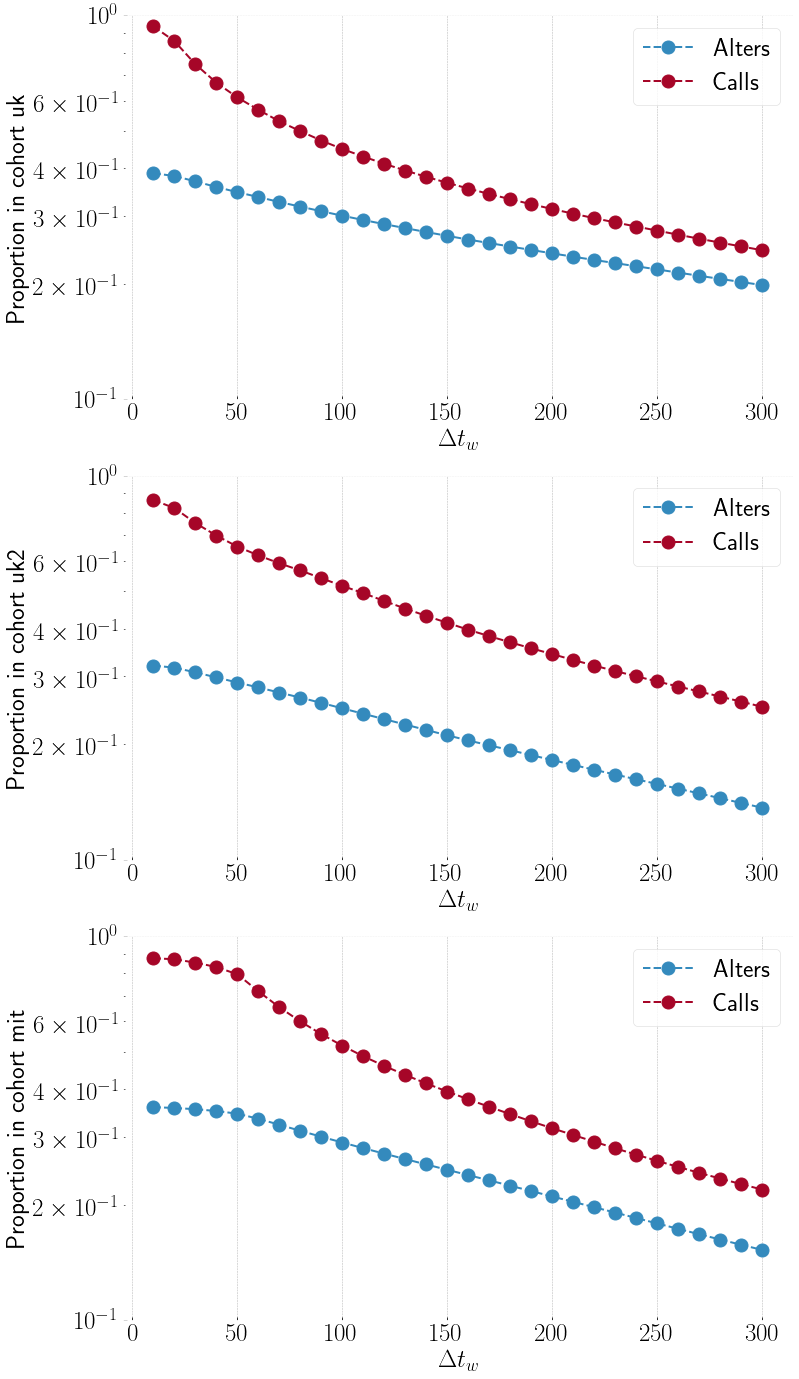

In [36]:
plt.figure(figsize=(12, 8*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3, 1, p)
    plt.xlabel(fr"$\Delta t_w$")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [37]:
counts['uk']

alters     calls
10   0.387743  0.935951
20   0.381454  0.856805
30   0.369265  0.745690
40   0.357101  0.667560
50   0.346087  0.611082
60   0.336185  0.567395
70   0.326292  0.529469
80   0.317354  0.499171
90   0.308729  0.471783
100  0.300527  0.448460
110  0.292858  0.428533
120  0.285688  0.410375
130  0.278957  0.394169
140  0.272498  0.379468
150  0.266335  0.366111
160  0.260467  0.353751
170  0.255022  0.342316
180  0.249809  0.331810
190  0.244706  0.322018
200  0.239740  0.312856
210  0.234989  0.304199
220  0.230451  0.296150
230  0.226142  0.288701
240  0.221918  0.281642
250  0.217756  0.274871
260  0.213606  0.268136
270  0.209584  0.261798
280  0.205698  0.255710
290  0.201903  0.249968
300  0.198216  0.244319

# Change $\gamma$ in Fig 3

In [38]:
survival4 = {}
for c in dff30.keys():
    survival4[c] = pc.get_survival(dff30[c], lambdamax=25, base=4)

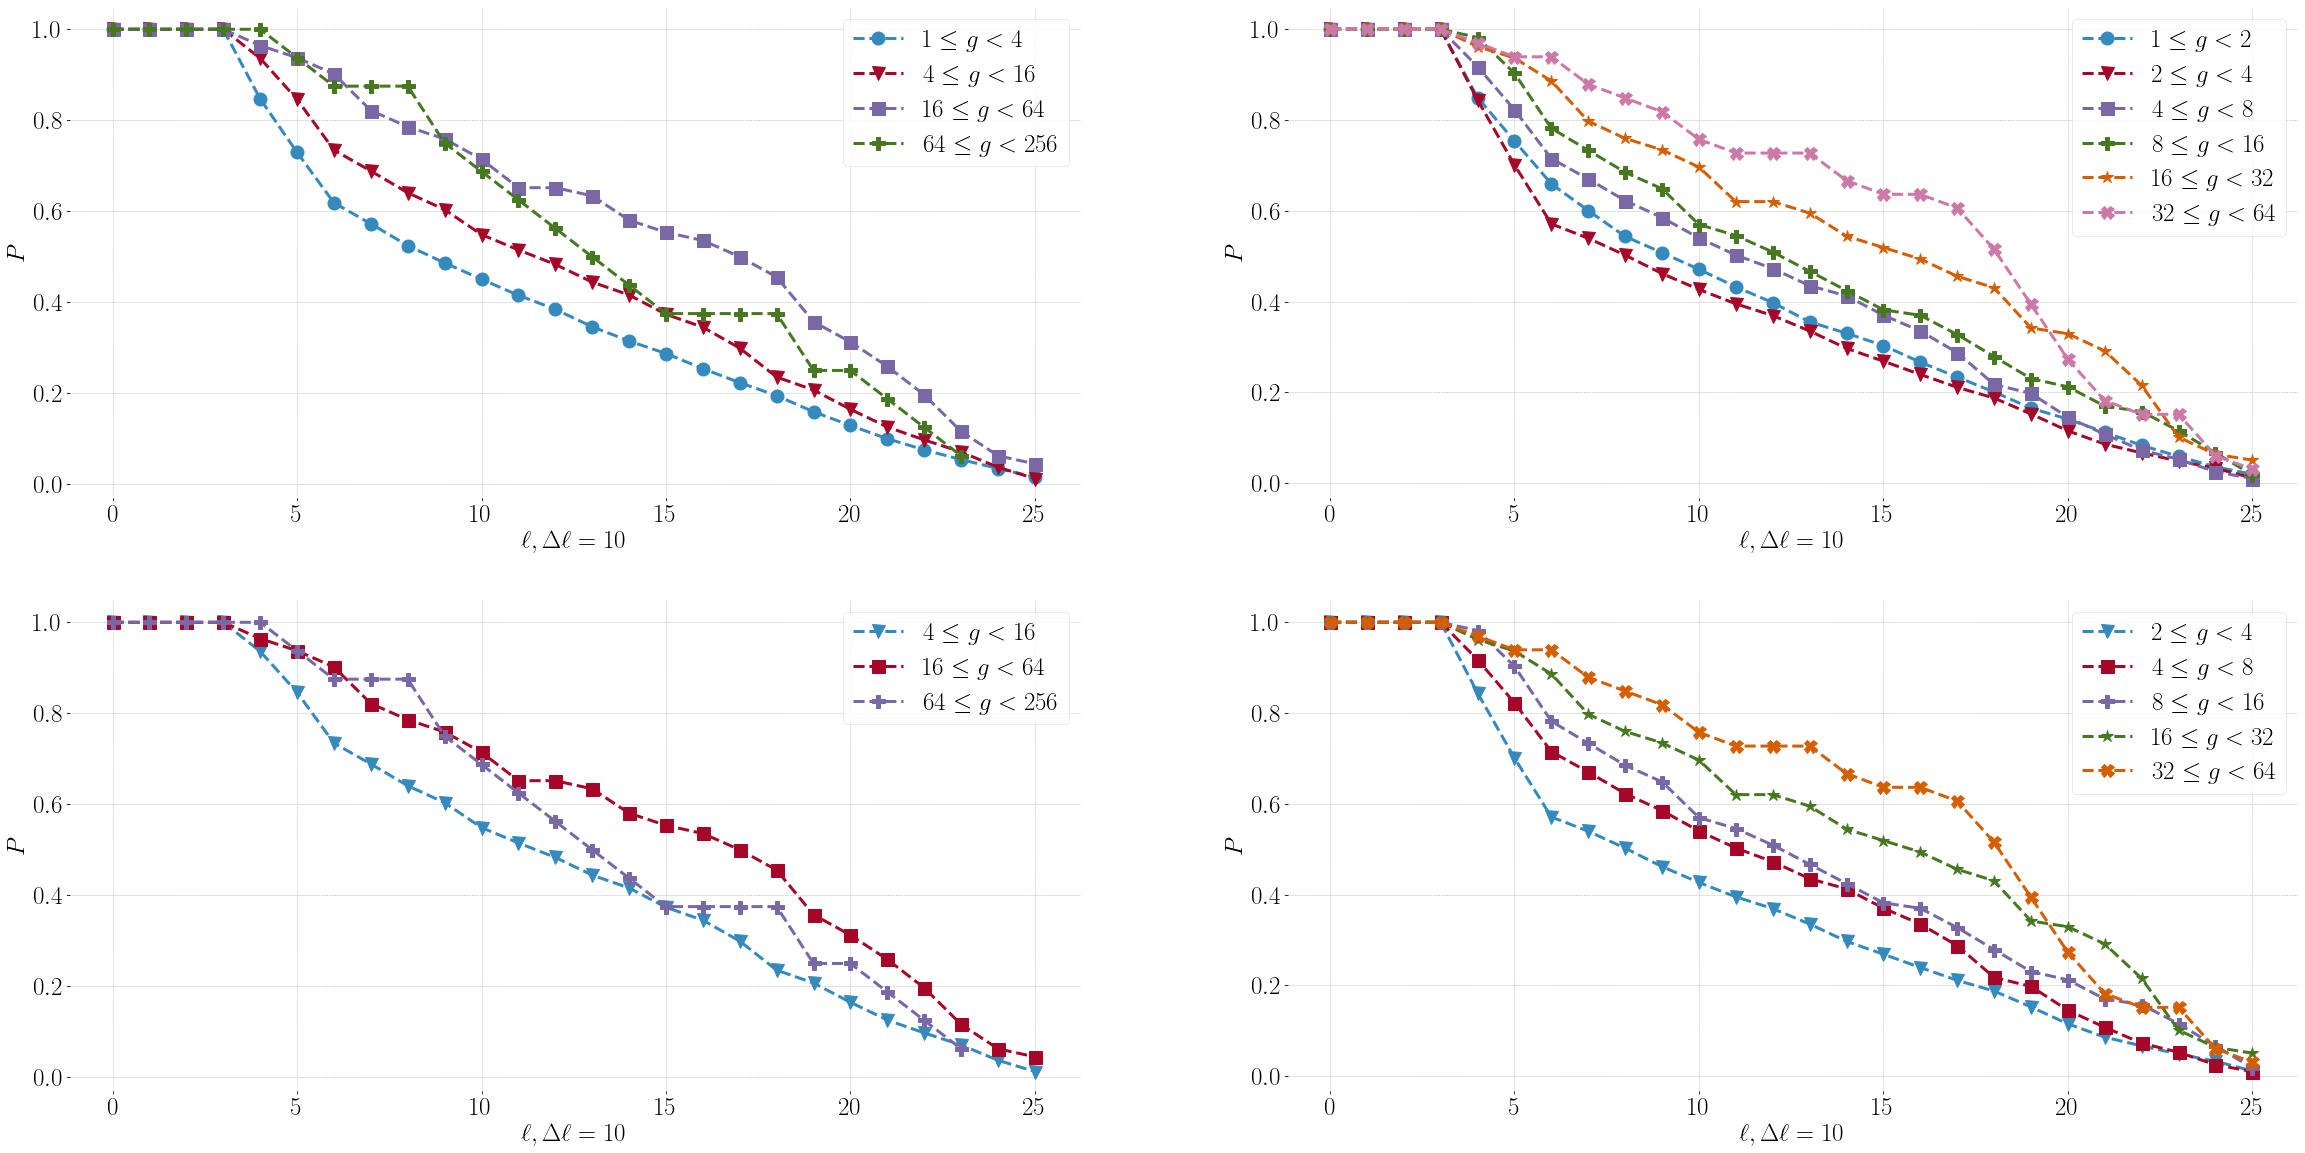

In [39]:
plt.figure(figsize=(20*2, 10*2))
plt.subplot(2,2,1)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()